In [1]:
import pandas as pd
import numpy as np
import brightway2 as bw
import uuid
from premise import *
import re
import pickle

import matplotlib.patches as mpatches  # Import for the legend patches
import matplotlib.lines as mlines  # Import for circle patches in the legend
import matplotlib.patches as patches

import seaborn as sns
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pycountry
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from tqdm import tqdm
import time
import wurst as w
from premise.geomap import Geomap

from functions_db import * # this is a python file with self-created functions needed to run this notebook
from config import * #some main key parameters needed.
from private_keys import * #import premise key
from mappings import *
from generate_figures import *

COUNTRY_CF_FILE = pd.read_csv(r"data\mean_cfs.csv").set_index('ISO_A3_EH')
new_db_name = "iea_facility_db_regionalized"
new_db_name_low_acts = "db_low_impact_acts_regionalized"
PROJECT_NAME

'iea_h2_lca'

for db in list(bd.databases):
    if 'not_regionalized' in str(db):
        print(db)
        del bw.databases[db]

## 1. User settings, identifying to make new dbs or calculate LCA impacts (if not stored):

In [2]:
#Create new iea activities corresponding with all H2 facilities in IEA database
create_new_iea_db = False
# to calculate end LCA impacts per facility
calc_lca_impacts = False

# if we regionalize, we need to import some functions to do so
if REGIONALIZE:
    from regionalization import match_best_location, relink_technosphere_exchanges

Adding REMIND and IMAGE topology using regionalization.py


In [3]:
import premise
premise.__version__

(2, 2, 7)

## 1.1. First, import the Excel file from IEA.

In [4]:
db_file_iea = pd.read_excel("data\IEA Hydrogen Production Projects Database_2024.xlsx", sheet_name='Projects',skiprows=10)
col_db_file_iea = pd.read_excel("data\IEA Hydrogen Production Projects Database_2024.xlsx", sheet_name='Projects')[2:3].values
db_file_iea.columns = col_db_file_iea[0]
db_file_iea_copy = db_file_iea.copy()
db_file_iea

C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():
C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


,Ref,Project name,Country,Date online,Decomission date,Status,Technology,Technology_details,Technology_electricity,Technology_electricity_details,...,Capacity_MWel,Capacity_Nm³ H₂/h,Capacity_kt H2/y,Capacity_t CO₂ captured/y,IEA zero-carbon estimated normalized capacity [Nm³ H₂/hour],References,Latitude,Longitude,Dummy_1,LOWE_CF
0,3,H2GO Energy Park Oude-Tonge - 1st phase,NLD,2025.0,NaN,FID/Construction,Other Electrolysis,Unknown PtX,Dedicated renewable,Others/Various,...,2.500000,555.555556,0.433133,NaN,555.555556,[503][630][609],51.703313,4.162536,Electrolysis,0.50
1,4,H2GO Energy Park Oude-Tonge - 2nd phase,NLD,2030.0,NaN,Concept,Other Electrolysis,Unknown PtX,Dedicated renewable,Others/Various,...,23.500000,5222.222222,4.071453,NaN,5222.222222,[503][630][609],51.703313,4.162536,Electrolysis,0.50
2,5,"NortH2, phase 1",NLD,2030.0,NaN,Feasibility study,Other Electrolysis,Unknown PtX,Dedicated renewable,Offshore wind,...,4000.000000,888888.888889,693.013333,NaN,888888.888889,[379],53.465208,6.632985,Electrolysis,0.55
3,6,Norsk e-Fuel Phase 1,NOR,2028.0,NaN,FID/Construction,SOEC,NaN,Dedicated renewable,Others/Various,...,50.263583,13227.258735,10.312500,NaN,13227.258735,[414] [521][1288][1449] [1693],65.840500,13.195267,Electrolysis,0.50
4,7,Norsk e-Fuel Phase 2,NOR,2028.0,NaN,Feasibility study,SOEC,NaN,Dedicated renewable,Others/Various,...,50.263583,13227.258735,10.312500,NaN,13227.258735,[414] [521][1288],65.840500,13.195267,Electrolysis,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2429,3156,Ammonia project Baytown complex,USA,2028.0,NaN,Concept,NG w CCUS,Unknown technology,NaN,NaN,...,NaN,230968.176096,180.072029,NaN,0.000000,[2741],29.755984,-95.365662,Fossil fuels with CCUS,0.90
2430,3157,IHI - ISCE2 SAF project,SGP,2025.0,NaN,DEMO,Other Electrolysis,Unknown PtX,Other/unknown,NaN,...,0.021067,4.681648,0.003650,NaN,4.681648,[2743],1.278304,103.785885,Electrolysis,0.57
2431,3158,H2 hub Bintulu Sarawak,MYS,NaN,NaN,Concept,Other Electrolysis,Unknown PtX,Other/Unknown,NaN,...,NaN,NaN,NaN,NaN,0.000000,[2744],3.167729,113.003280,Electrolysis,0.57
2432,3159,Nujio'qonik Green Hydrogen -phase 4,CAN,2030.0,NaN,Concept,Other Electrolysis,Unknown PtX,Dedicated renewable,Onshore wind,...,650.000000,144444.444444,112.614667,NaN,109024.678057,Data from World Energy GH2,48.522396,-58.434725,Electrolysis,0.40


### 1.2. Only consider columns with actual H2 production

In [5]:
numeric_columns = ['Capacity_kt H2/y']  # Add other columns if needed

# Step 2: Convert these columns to numeric, forcing errors to NaN
for column in numeric_columns:
    db_file_iea[column] = pd.to_numeric(db_file_iea[column], errors='coerce')

db_file_iea = db_file_iea[db_file_iea['Capacity_kt H2/y']>=0]

### 1.3 Now, we also filter out some plants based on several conditions:
* Very small pilot plants (less than 10t/a)
* Plants that are not decomissioned yet
* Projects older than 5 year and still not fully operational

In [6]:
min_plant_size = 10/1000 #kt/a
amount_before =db_file_iea['Capacity_kt H2/y'].sum()/1e3
min_plant_size

0.01

In [7]:
# Remove small plants and decommissioned ones + projects older than 5 year and still not fully operational
db_file_iea = db_file_iea[ (db_file_iea['Capacity_kt H2/y']>=min_plant_size) &
                             (db_file_iea['Status']!="Decommisioned") & ~( (db_file_iea['Date online'] <= 2019) &  # Projects from 2019 onward
    (db_file_iea['Status'] != 'Operational') ) ]  # Exclude non-operational old projects, if they are older than 5 years and still not operational       

# remove the ones only having refining as end product
list_del_end_uses = []#["EndUse_Iron&Steel"]#, "EndUse_Biofuels"]
# Check if "EndUse_Refining" column exists
for i, end_use in enumerate(list_del_end_uses):
    if end_use in db_file_iea.columns:
        col_start = 11
        col_stop = 25-i
        
        # Create a subset DataFrame with the columns between col_start and col_stop
        sub_df = db_file_iea.iloc[:, col_start:col_stop]
    
        # Calculate the sum of the specified columns for each row
        row_sums = sub_df.sum(axis=1)
    
        # Identify the rows where "EndUse_Refining" is '1' and the sum is '1'
        rows_to_drop = (db_file_iea[end_use] == 1) & (row_sums == 1)
    
        # Drop the rows
        db_file_iea = db_file_iea[~rows_to_drop]
    
        # Drop the "EndUse_Refining" column
        db_file_iea = db_file_iea.drop(end_use, axis=1)
        print("Rows and column deleted for {}".format(end_use))
db_file_iea

,Ref,Project name,Country,Date online,Decomission date,Status,Technology,Technology_details,Technology_electricity,Technology_electricity_details,...,Capacity_MWel,Capacity_Nm³ H₂/h,Capacity_kt H2/y,Capacity_t CO₂ captured/y,IEA zero-carbon estimated normalized capacity [Nm³ H₂/hour],References,Latitude,Longitude,Dummy_1,LOWE_CF
0,3,H2GO Energy Park Oude-Tonge - 1st phase,NLD,2025.0,NaN,FID/Construction,Other Electrolysis,Unknown PtX,Dedicated renewable,Others/Various,...,2.500000,555.555556,0.433133,NaN,555.555556,[503][630][609],51.703313,4.162536,Electrolysis,0.50
1,4,H2GO Energy Park Oude-Tonge - 2nd phase,NLD,2030.0,NaN,Concept,Other Electrolysis,Unknown PtX,Dedicated renewable,Others/Various,...,23.500000,5222.222222,4.071453,NaN,5222.222222,[503][630][609],51.703313,4.162536,Electrolysis,0.50
2,5,"NortH2, phase 1",NLD,2030.0,NaN,Feasibility study,Other Electrolysis,Unknown PtX,Dedicated renewable,Offshore wind,...,4000.000000,888888.888889,693.013333,NaN,888888.888889,[379],53.465208,6.632985,Electrolysis,0.55
3,6,Norsk e-Fuel Phase 1,NOR,2028.0,NaN,FID/Construction,SOEC,NaN,Dedicated renewable,Others/Various,...,50.263583,13227.258735,10.312500,NaN,13227.258735,[414] [521][1288][1449] [1693],65.840500,13.195267,Electrolysis,0.50
4,7,Norsk e-Fuel Phase 2,NOR,2028.0,NaN,Feasibility study,SOEC,NaN,Dedicated renewable,Others/Various,...,50.263583,13227.258735,10.312500,NaN,13227.258735,[414] [521][1288],65.840500,13.195267,Electrolysis,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2427,3154,Welspun ammonia project,IND,2029.0,NaN,Concept,Other Electrolysis,Unknown PtX,Other/Unknown,NaN,...,1721.442285,382542.730023,298.245614,NaN,382542.730023,[2739],23.606543,69.805089,Electrolysis,0.57
2428,3155,Blue Point complex Louisiana,USA,2028.0,NaN,Concept,NG w CCUS,Unknown technology,NaN,NaN,...,NaN,115484.088048,90.036014,NaN,0.000000,[2740],30.769032,-91.724450,Fossil fuels with CCUS,0.90
2429,3156,Ammonia project Baytown complex,USA,2028.0,NaN,Concept,NG w CCUS,Unknown technology,NaN,NaN,...,NaN,230968.176096,180.072029,NaN,0.000000,[2741],29.755984,-95.365662,Fossil fuels with CCUS,0.90
2432,3159,Nujio'qonik Green Hydrogen -phase 4,CAN,2030.0,NaN,Concept,Other Electrolysis,Unknown PtX,Dedicated renewable,Onshore wind,...,650.000000,144444.444444,112.614667,NaN,109024.678057,Data from World Energy GH2,48.522396,-58.434725,Electrolysis,0.40


### 1.4 Next, there are production facilities with different targeted end uses, redistribute the end uses equally and total should be '1' or 100%.

In [8]:
col_start = 11
col_stop = 25 - len(list_del_end_uses)
sub_df = db_file_iea.iloc[:,col_start:col_stop]
# Function to equally distribute 1s in a row
def distribute_ones(row):
    count_ones = row.sum()
    if count_ones > 1:
        row = row / count_ones
    return row

# Apply the function to each row
df_updated = sub_df.apply(distribute_ones, axis=1)
db_file_iea.loc[:, db_file_iea.columns[col_start:col_stop]] = df_updated.values
df_updated

,EndUse_Refining,EndUse_Ammonia,EndUse_Methanol,EndUse_Iron&Steel,EndUse_Other Ind,EndUse_Mobility,EndUse_Power,EndUse_Grid inj.,EndUse_CHP,EndUse_Domestic heat,EndUse_Biofuels,EndUse_Synfuels,EndUse_CH4 grid inj.,EndUse_CH4 mobility
0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.5,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2428,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2429,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2432,NaN,0.333333,NaN,NaN,NaN,NaN,0.333333,0.333333,NaN,NaN,NaN,NaN,NaN,NaN


### 1.5 Handle rows without any End use, this is not fair as H2 is still produced, however, not known for what end use, thus we assume hydrogen as end-product

In [9]:
db_file_iea['EndUse_H2'] = 0
rows_with_only_nans = df_updated.isna().all(axis=1)
db_file_iea.loc[rows_with_only_nans, 'EndUse_H2'] = 1
db_file_iea[db_file_iea['EndUse_H2']==1]

,Ref,Project name,Country,Date online,Decomission date,Status,Technology,Technology_details,Technology_electricity,Technology_electricity_details,...,Capacity_Nm³ H₂/h,Capacity_kt H2/y,Capacity_t CO₂ captured/y,IEA zero-carbon estimated normalized capacity [Nm³ H₂/hour],References,Latitude,Longitude,Dummy_1,LOWE_CF,EndUse_H2
10,15,ARIES project,USA,2022.0,NaN,DEMO,PEM,NaN,Other/unknown,NaN,...,1.923077e+02,0.149931,NaN,192.307692,[613] [614] [1618],39.818347,-105.090850,Electrolysis,0.57,1
79,113,"Baicheng, Jilin wind-solar project",CHN,2035.0,NaN,Concept,Other Electrolysis,Unknown PtX,Dedicated renewable,Others/Various,...,2.565287e+06,2000.000000,NaN,NaN,[773],45.668289,122.846380,Electrolysis,0.50,1
248,585,NEOM Green Hydrogen Project,SAU,2026.0,NaN,FID/Construction,ALK,NaN,Dedicated renewable,Others/Various,...,4.782609e+05,372.871304,NaN,478260.869565,[562][1186] [1297] [1666],28.305908,34.849285,Electrolysis,0.50,1
252,589,Project NEO,AUS,2027.0,NaN,Concept,Other Electrolysis,Unknown PtX,Dedicated renewable,Others/Various,...,2.222222e+05,173.253333,NaN,222222.222222,[520],0.000000,0.000000,Electrolysis,0.50,1
282,626,Methane Synthesis test facility in Koshijihara...,JPN,2019.0,NaN,Operational,Other Electrolysis,Unknown PtX,Other/unknown,NaN,...,1.600000e+01,0.012474,NaN,16.000000,[489],0.000000,0.000000,Electrolysis,0.57,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2422,3149,H2 project Coesfeld area,DEU,2028.0,NaN,Concept,Other Electrolysis,Unknown PtX,Other/Unknown,NaN,...,1.111111e+04,8.662667,NaN,11111.111111,[2734],51.938570,7.172088,Electrolysis,0.57,1
2423,3150,H2 project US Gulf coast,USA,2025.0,NaN,Concept,Other Electrolysis,Unknown PtX,Other/Unknown,NaN,...,4.444444e+03,3.465067,NaN,4444.444444,[2735],29.729292,-95.387609,Electrolysis,0.57,1
2425,3152,Eneos project,USA,2030.0,NaN,Concept,NG w CCUS,Unknown Technology,NaN,NaN,...,3.135350e+05,244.444444,NaN,0.000000,[2738],29.663397,-92.464653,Fossil fuels with CCUS,0.90,1
2427,3154,Welspun ammonia project,IND,2029.0,NaN,Concept,Other Electrolysis,Unknown PtX,Other/Unknown,NaN,...,3.825427e+05,298.245614,NaN,382542.730023,[2739],23.606543,69.805089,Electrolysis,0.57,1


db_file_iea[['Technology',	'Technology_details',	'Technology_electricity',	'Technology_electricity_details', "LOWE_CF"]].groupby(['Technology',	'Technology_details',	'Technology_electricity',	'Technology_electricity_details']).mean()

### 1.6 calculating the hydrogen production amounts per year considering the capacity factor of the plant.

In [10]:
db_file_iea = db_file_iea[db_file_iea['LOWE_CF']>=0] # remove rows where there is no CF defined
db_file_iea['amount_kt H2/y'] = db_file_iea['Capacity_kt H2/y'] * db_file_iea['LOWE_CF']
db_file_iea['REN_CF']= "" # add new column for the cf of the renewable
db_file_iea['amount_kt H2/y'].sum()/1e3

C:\Users\terlouw_t\AppData\Local\Temp\ipykernel_23224\2642278901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_file_iea['amount_kt H2/y'] = db_file_iea['Capacity_kt H2/y'] * db_file_iea['LOWE_CF']
C:\Users\terlouw_t\AppData\Local\Temp\ipykernel_23224\2642278901.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_file_iea['REN_CF']= "" # add new column for the cf of the renewable


109.85087139036021

In [11]:
amount_after = db_file_iea['Capacity_kt H2/y'].sum()/1e3
amount_after/amount_before

0.9999819391039428

### 1.7 Next, import file with LCA act information:
* one sheet that matches end applications with LCA activities including reference activity use for end product;
* one sheet for matching hydrogen production types for IEA file with LCA activities in the background LCA databases.

In [12]:
lca_acts_prod = pd.read_excel("data\LCA_act_overview.xlsx", sheet_name='h2_product', index_col = 'End use', nrows=17).fillna("nan")
lca_acts_matcher = pd.read_excel("data\LCA_act_overview.xlsx", sheet_name='h2_matcher', index_col = [0,1,2,3]).fillna("nan").iloc[:, :4]
lca_acts_matcher

act_name  \
Technology         Technology_details                     Technology_electricity Technology_electricity_details                                                      
Other Electrolysis Unknown PtX                            grid+renewables        offshore wind                   hydrogen production, gaseous, 30 bar, from PEM...   
                                                                                 onshore wind                    hydrogen production, gaseous, 30 bar, from PEM...   
                                                                                 solar pv                        hydrogen production, gaseous, 30 bar, from PEM...   
                                                                                 hydropower                      hydrogen production, gaseous, 30 bar, from PEM...   
                                                                                 unknown                                              location specific renewables   
...                                                                                                                                                            ...   
Coal w CCUS        NaN                                    NaN                    NaN                              hydrogen production, coal gasification, with CCS   
Oil w CCUS         Petcoke+biomass gasification with CCUS NaN                    NaN                              hydrogen production, coal gasification, with CCS   
                   Heavy oil residue gasification+CCUS    NaN                    NaN                              hydrogen production, coal gasification, with CCS   
Other              Waste gasification CCUS                NaN                    NaN                             hydrogen production, gaseous, 25 bar, from gas...   
                   Methane pyrolysis                      NaN                    NaN                             hydrogen production, gaseous, 100 bar, from me...   

                                                                                                                                     ref_product  \
Technology         Technology_details                     Technology_electricity Technology_electricity_details                                    
Other Electrolysis Unknown PtX                            grid+renewables        offshore wind                         hydrogen, gaseous, 30 bar   
                                                                                 onshore wind                          hydrogen, gaseous, 30 bar   
                                                                                 solar pv                              hydrogen, gaseous, 30 bar   
                                                                                 hydropower                            hydrogen, gaseous, 30 bar   
                                                                                 unknown                            location specific renewables   
...                                                                                                                                          ...   
Coal w CCUS        NaN                                    NaN                    NaN                             hydrogen, gaseous, low pressure   
Oil w CCUS         Petcoke+biomass gasification with CCUS NaN                    NaN                             hydrogen, gaseous, low pressure   
                   Heavy oil residue gasification+CCUS    NaN                    NaN                             hydrogen, gaseous, low pressure   
Other              Waste gasification CCUS                NaN                    NaN                                   hydrogen, gaseous, 25 bar   
                   Methane pyrolysis                      NaN                    NaN                                  hydrogen, gaseous, 100 bar   

                                                                      

### 2. Set Brighway project

In [13]:
# Import project
bw.projects.set_current(PROJECT_NAME) #Creating/accessing the project
DB_NAME_INIT,PROJECT_NAME

('ecoinvent-3.10-cutoff', 'iea_h2_lca')

### 3. Next, we are going to create a new database where we generate a new activity for each H2 production facility, coupling that to some of the newly generated LCA activities in the previous step

In [14]:
def create_supply_exchanges(exc_add, amount, db_name):
    """
    Generate a list of supply exchanges for hydrogen distribution infrastructure, including pipelines, storage, 
    and electricity requirements. The function dynamically retrieves electricity market data from the Brightway2 
    database based on the specified location.

    Parameters:
    ----------
    exc_add : dict
        A dictionary defining the main hydrogen supply exchange, which includes keys like 'name', 'type', 
        'location', 'reference product', and 'unit'.
    
    amount : float
        The base quantity for hydrogen, used to calculate proportional amounts for each exchange in the supply chain.
    
    db_name : str
        The name of the Brightway2 database to use for fetching the electricity market data. This database 
        should contain relevant activity data for hydrogen and electricity supply chains.

    Returns:
    -------
    exchanges : list of dict
        A list of dictionaries, each representing a supply exchange for hydrogen distribution. The entries cover various 
        technologies (pipelines, compressors, storage, and electricity) and specify the type, location, reference product, 
        unit, and calculated amount. For electricity, the amount is dynamically calculated from the retrieved activity.

    Example:
    -------
    Call the function with a defined hydrogen exchange and location for electricity data:

    Notes:
    ------
    - The 'amount' for 'hydrogen, gaseous, low pressure' includes hydrogen losses from storage.
    """
    db_sel = database_sel[db_name]
    
    exchanges = [
        {
            'name': exc_add['name'],
           'type': exc_add['type'],
            'location': exc_add['location'],
            'reference product': exc_add['reference product'],
            'unit': exc_add['unit'],
           'amount': amount * 0.00691434837611582, # includes H2 storage loss
            'input': (db_name, w.get_one(db_sel,
                                w.equals("name", exc_add['name']),
                                w.equals("reference product", exc_add['reference product']),
                                w.equals("location", exc_add['location']) )['code'])
        },
        {
            'name': 'pipeline, hydrogen, low pressure distribution network',
            'type': 'technosphere',
            'location': 'RER',
            'reference product': 'pipeline, for hydrogen distribution',
            'unit': 'kilometer',
            'amount': amount * 1.1442208504274044e-06,
            'input': (db_name, w.get_one(db_sel,
                                w.equals("name", 'pipeline, hydrogen, low pressure distribution network'),
                                w.equals("reference product", 'pipeline, for hydrogen distribution'),
                                w.equals("location", 'RER') )['code'])
        },
        {
            'name': 'pipeline, hydrogen, high pressure transmission network',
            'type': 'technosphere',
            'location': 'RER',
            'reference product': 'pipeline, for hydrogen transmission',
            'unit': 'kilometer',
            'amount': amount * 2.0170559863303602e-09,
            'input': (db_name, w.get_one(db_sel,
                                w.equals("name", 'pipeline, hydrogen, high pressure transmission network'),
                                w.equals("reference product", 'pipeline, for hydrogen transmission'),
                                w.equals("location", 'RER') )['code'])
        },
        {
            'name': 'compressor assembly for transmission hydrogen pipeline',
            'type': 'technosphere',
            'location': 'RER',
            'reference product': 'compressor, for hydrogen transmission',
            'unit': 'unit',
            'amount': amount *  3.227031001926499e-11,
            'input': (db_name, w.get_one(db_sel,
                                w.equals("name", 'compressor assembly for transmission hydrogen pipeline'),
                                w.equals("reference product", 'compressor, for hydrogen transmission'),
                                w.equals("location", 'RER') )['code'])
        },
        {
            'name': 'geological hydrogen storage',
            'type': 'technosphere',
            'location': 'RER',
            'reference product': 'hydrogen storage',
            'unit': 'kilogram',
            'amount': amount *  0.30207430451283473,
            'input': (db_name, w.get_one(db_sel,
                                w.equals("name", 'geological hydrogen storage'),
                                w.equals("reference product", 'hydrogen storage'),
                                w.equals("location", 'RER') )['code'])
        },
        {
            'name': 'Hydrogen',
            'type': 'biosphere',
            'categories': 'air::',
            'unit': 'kilogram',
            'amount': amount * 0.00691434837611582,
            'input': (BIOSPHERE_DB, w.get_one(bio_db_w,
                                w.equals("name", 'Hydrogen'),
                                w.equals("unit", 'kilogram'),
                                w.equals("categories", ('air',)) )['code'])
        },
        {     'name': 'market group for electricity, low voltage',#act_find['name'],
              'amount': amount * (1.0291066405763645 + 0.6444251829607142 + 0.14302201400538245),
              'location': "GLO", #act_find['location'],
              'unit': 'kilowatt hour', #act_find['unit'],
              'type': 'technosphere',
              'reference product': 'electricity, low voltage',
                'input': (db_name, w.get_one(db_sel,
                                    w.equals("name", 'market group for electricity, low voltage'),
                                    w.equals("reference product", 'electricity, low voltage'),
                                    w.equals("location", 'GLO') )['code'])
        }
    ]
    
    return exchanges

In [15]:
# write the databases as wurst ones, so we can use it to modify later...
if create_new_iea_db:
    ref_db_w = w.extract_brightway2_databases(NAME_REF_DB, add_properties=False, add_identifiers=False)
    ref_db_w_2030 = w.extract_brightway2_databases('ecoinvent_remind_SSP2-PkBudg1150_2030_base', add_properties=False, add_identifiers=False)
    ref_db_w_2035 = w.extract_brightway2_databases('ecoinvent_remind_SSP2-PkBudg1150_2035_base', add_properties=False, add_identifiers=False)
    ref_db_w_2040 = w.extract_brightway2_databases('ecoinvent_remind_SSP2-PkBudg1150_2040_base', add_properties=False, add_identifiers=False)
    bio_db_w = w.extract_brightway2_databases(BIOSPHERE_DB, add_properties=False, add_identifiers=False)

    database_sel = {NAME_REF_DB:ref_db_w,
                    BIOSPHERE_DB:bio_db_w,
                    'ecoinvent_remind_SSP2-PkBudg1150_2030_base':ref_db_w_2030,
                    'ecoinvent_remind_SSP2-PkBudg1150_2035_base': ref_db_w_2035,
                    'ecoinvent_remind_SSP2-PkBudg1150_2040_base':ref_db_w_2040,
                   }

In [16]:
def generate_exchanges(h2_act, end_product_act, db_name, ei_loc="", 
                       regionalize=REGIONALIZE, regionalize_exemption = ['fossil fuel']
                      ):
    """
    Generates exchanges for an end product activity, incorporating hydrogen production details.

    Parameters:
    h2_act (list): A list containing details of the hydrogen production activity.
        - h2_act[0] (str): The name of the hydrogen activity.
        - h2_act[1] (str): The reference product of the hydrogen activity.
        - h2_act[2] (str): The location of the hydrogen activity.
    end_product_act (list): A list containing details of the end product activity.
        - end_product_act[0] (str): The name of the end product activity.
        - end_product_act[1] (str): The reference product of the end product activity.
        - end_product_act[2] (str): The location of the end product activity.

    Returns:
    tuple: A tuple containing:
        - exchanges (list): A list of exchanges for the end product activity.
        - h2_amount (float): The hydrogen required for the end product activity.
    """
    exchanges = []
    h2_amount = 0 #count amount of hydrogen per FU
    h2_exch_checker = 0 #to check whether we have an H2 exchange introduced/modified. If not, throw an error

    # get the wurst database
    db_sel = database_sel[db_name]

    if end_product_act[0] in regionalize_exemption:
        pass
        #print(f"Activity {end_product_act[0]} not regionalized since it is in the exemption list")

    """First, we will search in the database for the best matching activity to the location"""
    # Do NOT include the location yet in this search
    activities_to_adapt_init = w.get_many(
                                db_sel,
                                w.equals("name", end_product_act[0]),
                                w.equals("reference product", end_product_act[1]),
                            )

    possible_locations = [act['location'] for act in activities_to_adapt_init]

    # This is the best matching location for the hydrogen application:
    best_matched_loc_app = match_best_location(ei_loc, possible_locations, fallback=end_product_act[2])[0] if len(possible_locations) > 1 else end_product_act[2]
            
    """ Now, we are going to modify some exchanges, mainly those from hydrogen under different levels"""
    if (end_product_act[0] != "") and (end_product_act[0] != "nan"):
        act_select = w.get_one(db_sel,
                                        w.equals("name", end_product_act[0]),
                                        w.equals("reference product", end_product_act[1]),
                                        w.equals("location", best_matched_loc_app)
                                    )
        act_select = act_select.copy()
        
        # If we apply regionalization, we will make a copy, change the location, and regionalize all exchanges.
        if regionalize and end_product_act[0] not in regionalize_exemption:
            act_select['location'] = ei_loc
            act_select = relink_technosphere_exchanges(act_select, db_sel, contained=False)

        # for some end products, the hydrogen production exchange is one level lower embedded, we have to find it and modify...
        if end_product_act[0] in list(dict_special_exch.keys() ):
            for exc in act_select['exchanges']:
                exc = exc.copy()
                exc['reference product'] = exc.get('product', exc.get('reference product'))

                #print(exc['type'], exc, end_product_act)
                if (exc['type'] == 'technosphere') and (exc['name'] == dict_special_exch[end_product_act[0]]):
                    level_2_act = w.get_one(db_sel,
                                w.equals("name", exc['name']),
                                w.equals("reference product", exc['product']),
                                w.equals("unit", exc['unit']),
                                w.equals("location", exc['location']) )
                    
                    level_2_act = level_2_act.copy()

                    # If we apply regionalization, we will make a copy, change the location, and regionalize all exchanges.
                    if regionalize and end_product_act[0] not in regionalize_exemption:
                        level_2_act['location'] = ei_loc
                        level_2_act = relink_technosphere_exchanges(level_2_act, db_sel, contained=False)
                    
                    #loop over exchanges from exchanges
                    for exc_2 in level_2_act['exchanges']:
                        exc_2 = exc_2.copy()
                        # Add reference product since this was not always correctly defined.
                        exc_2['reference product'] = exc_2.get('product', exc_2.get('reference product'))
                        
                        if ( dict_special_exch_2.get(end_product_act[0]) is not None 
                            and (exc_2['type'] == 'technosphere') and 
                            (exc_2['name'] == dict_special_exch_2[end_product_act[0]]) ):
                            # then,we have to modify hydrogen source also here, two levels deeper...
                            level_3_act = w.get_one(db_sel,
                                            w.equals("name", exc_2['name']),
                                            w.equals("reference product", exc_2['product']),
                                            w.equals("unit", exc_2['unit']),
                                            w.equals("location", exc_2['location']) )
                            level_3_act = level_3_act.copy()

                            # If we apply regionalization, change the location, and regionalize all exchanges.
                            if regionalize and end_product_act[0] not in regionalize_exemption:
                                level_3_act['location'] = ei_loc
                                level_3_act = relink_technosphere_exchanges(level_3_act, db_sel, contained=False)

                            for exc_3 in level_3_act['exchanges']:
                                exc_3 = exc_3.copy()
                                # Add reference product since this was not always correctly defined.
                                exc_3['reference product'] = exc_3.get('product', exc_3.get('reference product'))
                                    
                                if (exc_3['type'] == 'technosphere') and ("hydrogen, gaseous" in str(exc_3['reference product'])): 
                                    code_h2 = w.get_one(db_sel,
                                        w.equals("name", h2_act[0]),
                                        w.equals("reference product", h2_act[1]),
                                        w.equals("unit", 'kilogram'),
                                        w.equals("location", h2_act[2]) )['code'] 
                                    
                                    # Add hydrogen production activity:
                                    exc_add = {'name': h2_act[0],
                                              'amount': exc['amount']*exc_2['amount']*exc_3['amount'],
                                              'location': h2_act[2],
                                              'unit': 'kilogram',
                                              'type': 'technosphere',
                                              'reference product': h2_act[1],
                                              'input': (db_name, code_h2)}
                                    
                                    exchanges.append(exc_add)
                    
                                    h2_amount += exc['amount']*exc_2['amount']*exc_3['amount']
                                    h2_exch_checker = 1

                                #add other biosphere or technosphere activities
                                elif exc_3['type']=='technosphere':
                                    exc_3['amount'] = exc['amount']*exc_2['amount']*exc_3['amount']
                                    exc_3['input'] = (db_name, w.get_one(db_sel,
                                                    w.equals("name", exc_3['name']),
                                                    w.equals("reference product", exc_3['product']),
                                                    w.equals("unit", exc_3['unit']),
                                                    w.equals("location", exc_3['location']) )['code'])
                                    
                                    exchanges.append(exc_3)

                                elif exc_3['type']=='biosphere':
                                    exc_3['amount'] = exc['amount']*exc_2['amount']*exc_3['amount']
                                    exc_3['input'] = (BIOSPHERE_DB, w.get_one(bio_db_w,
                                                w.equals("name", exc_3['name']),
                                                w.equals("unit", exc_3['unit']),
                                                w.equals("categories", exc_3['categories']) )['code'])
                                    exchanges.append(exc_3)

                        #Technosphere exchange, check if there is hydrogen as exchange, in that case, modify 
                        elif (exc_2['type'] == 'technosphere') and ("hydrogen, gaseous" in str(exc_2['reference product'])): 
                        # take the product/activity with hydrogen gas and modify
                            # Add H2 activity
                            code_h2 = w.get_one(db_sel,
                                w.equals("name", h2_act[0]),
                                w.equals("reference product", h2_act[1]),
                                w.equals("unit", 'kilogram'),
                                w.equals("location", h2_act[2]) )['code'] 
                            
                            # Add hydrogen production activity:
                            exc_add = {'name': h2_act[0],
                                      'amount':  exc['amount']*exc_2['amount'],
                                      'location': h2_act[2],
                                      'unit': 'kilogram',
                                      'type': 'technosphere',
                                      'reference product': h2_act[1],
                                      'input': (db_name, code_h2)}

                            exchanges.append(exc_add)
            
                            h2_amount += exc['amount']*exc_2['amount']
                            h2_exch_checker = 1

                            # However, sometimes we need to add transport and storage of H2, as those are also included in the initital LCIs
                            if exc_2['name'] == 'hydrogen supply, distributed by pipeline':
                                #print("EXTRA EXCHANGES GENERATED FOR 'hydrogen supply, distributed by pipeline' {}".format(end_product_act))
                                supp_exc = create_supply_exchanges(exc_add, exc['amount']*exc_2['amount'], db_name)
                                exchanges.extend(supp_exc)

                                h2_amount += exc['amount']*exc_2['amount']*0.006914348 #0.006914348 is the loss factor
                                    
                        #biosphere or technosphere activity
                        elif exc_2['type']=='technosphere':
                            exc_2['amount'] = exc['amount']*exc_2['amount']
                            exc_2['input'] = (db_name, w.get_one(db_sel,
                                            w.equals("name", exc_2['name']),
                                            w.equals("reference product", exc_2['product']),
                                            w.equals("unit", exc_2['unit']),
                                            w.equals("location", exc_2['location']) )['code'])
                            exchanges.append(exc_2)

                        elif exc_2['type']=='biosphere':
                            exc_2['amount'] = exc['amount']*exc_2['amount']
                            exc_2['input'] = (BIOSPHERE_DB, w.get_one(bio_db_w,
                                        w.equals("name", exc_2['name']),
                                        w.equals("unit", exc_2['unit']),
                                        w.equals("categories", exc_2['categories']) )['code'])
                            exchanges.append(exc_2)

                elif exc['type']=='technosphere':
                    exc['input'] = (db_name, w.get_one(db_sel,
                                    w.equals("name", exc['name']),
                                    w.equals("reference product", exc['product']),
                                    w.equals("unit", exc['unit']),
                                    w.equals("location", exc['location']) )['code'])
                    exchanges.append(exc)
                            
                elif exc['type']=='biosphere':
                    exc['input'] = (BIOSPHERE_DB, w.get_one(bio_db_w,
                                w.equals("name", exc['name']),
                                w.equals("unit", exc['unit']),
                                w.equals("categories", exc['categories']) )['code'])
                    exchanges.append(exc)
        # Loop over exchanges and add them, except for the hydrogen-related one since the source is specifically determined
        else:
            act_select = act_select.copy()
            # If we apply regionalization, change the location, and regionalize all exchanges.
            if regionalize and end_product_act[0] not in regionalize_exemption:
                act_select['location'] = ei_loc
                act_select = relink_technosphere_exchanges(act_select, db_sel, contained=False)
                
            for exc in act_select['exchanges']:
                exc=exc.copy()
                    
                exc['reference product'] = exc.get('product', exc.get('reference product'))
                    
                if exc['type'] == 'technosphere': 
                    if ("hydrogen, gaseous" in str(exc['reference product'])): # take the product/activity with hydrogen gas and modify
                        # Add H2 activity
                        code_h2 = w.get_one(db_sel,
                            w.equals("name", h2_act[0]),
                            w.equals("reference product", h2_act[1]),
                            w.equals("unit", 'kilogram'),
                            w.equals("location", h2_act[2]) )['code'] 
                        
                        # Add hydrogen production activity:
                        exc_add = {'name': h2_act[0],
                                  'amount':  exc['amount'],
                                  'location': h2_act[2],
                                  'unit': 'kilogram',
                                  'type': 'technosphere',
                                  'reference product': h2_act[1],
                                  'input': (db_name, code_h2)}
                        
                        exchanges.append(exc_add)
                        
                        h2_exch_checker = 1 #hydrogen activity included
                        # Summing H2 introduced in case there are multiple exchanges with H2, see:
                        # 'heat, residential, by conversion of hydrogen using a fuel cell, PEM, allocated by exergy, distributed by pipeline, produced by Electrolysis, PEM using electricity from grid'
                        h2_amount+=exc['amount']

                        # However, sometimes we need to add transport and storage of H2, as those are also included in the initital LCIs
                        if exc['name'] == 'hydrogen supply, distributed by pipeline':
                            print("EXTRA EXCHANGES GENERATED FOR 'hydrogen supply, distributed by pipeline' {}".format(end_product_act))
                            supp_exc = create_supply_exchanges(exc_add, exc['amount'], db_name)
                            exchanges.extend(supp_exc)

                            h2_amount+=exc['amount']*0.006914348,#0.006914348 is the loss factor
                        
                    #add the other technosphere exchanges    
                    elif exc['type']=='technosphere':
                        exc['input'] = (db_name, w.get_one(db_sel,
                                        w.equals("name", exc['name']),
                                        w.equals("reference product", exc['product']),
                                        w.equals("unit", exc['unit']),
                                        w.equals("location", exc['location']) )['code'])
                        exchanges.append(exc)
                                
                    elif exc['type']=='biosphere':
                        exc['input'] = (BIOSPHERE_DB, w.get_one(bio_db_w,
                                    w.equals("name", exc['name']),
                                    w.equals("unit", exc['unit']),
                                    w.equals("categories", exc['categories']) )['code'])
                        exchanges.append(exc)
                        
                #add biosphere exchanges        
                elif exc['type']=='biosphere':
                    exc['input'] = (BIOSPHERE_DB, w.get_one(bio_db_w,
                                w.equals("name", exc['name']),
                                w.equals("unit", exc['unit']),
                                w.equals("categories", exc['categories']) )['code'])
                    exchanges.append(exc)
                
    # add hydrogen only         
    else:
        # Add H2 activity
        code_h2 = w.get_one(db_sel,
            w.equals("name", h2_act[0]),
            w.equals("reference product", h2_act[1]),
            w.equals("unit", 'kilogram'),
            w.equals("location", h2_act[2]) )['code'] 
        
        # Add hydrogen production activity:
        exc_add = {'name': h2_act[0],
                  'amount':  1,
                  'location': h2_act[2],
                  'unit': 'kilogram',
                  'type': 'technosphere',
                  'reference product': h2_act[1],
                  'input': (db_name, code_h2)}
        
        exchanges.append(exc_add)
        h2_amount += 1
        h2_exch_checker=1

    if h2_exch_checker == 0:
        raise ValueError(f"No hydrogen exchange for H2 act '{h2_act}' in end product '{end_product_act}'")
        
    return exchanges, h2_amount

### 3.1 Those end-products require additional treatment in `generate_exchanges` code above, since the modified hydrogen exchange is one level or even two levels lower embedded as sub-exchange.

In [17]:
# Those end-products require additional treatment in code below, since the modified hydrogen exchange is one level lower embedded as sub-exchange.
dict_special_exch = {#1 kerosene production, hydrogen one level lower under syngas, RWGS, Production, for Fischer Tropsch process, hydrogen from electrolysis
                    "kerosene production, synthetic, Fischer Tropsch process, hydrogen from electrolysis, energy allocation incl. combustion":
                    "syngas, RWGS, Production, for Fischer Tropsch process, hydrogen from electrolysis",
                     #2 heat production, H2 supply one level down under 'hydrogen supply, distributed by pipeline'
                     "heat, residential, by combustion of hydrogen using CHP, allocated by exergy, distributed by pipeline, produced by Electrolysis, PEM using electricity from grid":
                     "hydrogen supply, distributed by pipeline",
                     #3 heat production, the hydrogen activity is under storage on second level
                     "heat production, from hydrogen-fired one gigawatt gas turbine": 
                    "hydrogen storage, for grid-balancing",
                     #4 domestic heat production, H2 supply one level down under "hydrogen supply, distributed by pipeline"
                     "heat, residential, by combustion of hydrogen using boiler, distributed by pipeline, produced by Electrolysis, PEM using electricity from grid":
                     "hydrogen supply, distributed by pipeline",                
                    #5 large-scale power production, one level lower under "hydrogen, gaseous, 80 bar"
                    "electricity production, from hydrogen-fired one gigawatt gas turbine":
                    "hydrogen storage, for grid-balancing",
                    #6 Steel production under H2-DRI, iron production"
                    "H2-DRI-EAF, steel production, low-alloyed":
                    "H2-DRI, iron production",   
                    #6.1 Steel production under H2-DRI, iron production"
                    "H2-DRI-EAF, steel production, low-alloyed, foreground changed":
                    "H2-DRI, iron production, foreground changed",  
                    #6 Use of synthetic methane in vehicles"
                    "transport, passenger car, compressed electrochemical gas, Medium, EURO-6":
                    "methane, from electrochemical methanation, with carbon from atmosphere"
                    }

dict_special_exch_2 = {#1 kerosene production, hydrogen two levels lower under carbon monoxide, from RWGS, for Fischer Tropsch process, hydrogen from electrolysis
                    "kerosene production, synthetic, Fischer Tropsch process, hydrogen from electrolysis, energy allocation incl. combustion":
                    "carbon monoxide, from RWGS, for Fischer Tropsch process, hydrogen from electrolysis"}

In [18]:
end_product_act = ("heat, residential, by combustion of hydrogen using CHP, allocated by exergy, distributed by pipeline, produced by Electrolysis, PEM using electricity from grid",	
 'heat, from residential heating system',	'RER')

end_product_act = ('kerosene production, synthetic, Fischer Tropsch process, hydrogen from electrolysis, energy allocation incl. combustion',	
                   'kerosene, synthetic',	'RER')

h2_act = ('hydrogen production, coal gasification, with CCS',	'hydrogen, gaseous, low pressure',	'RoW')
#generate_exchanges(h2_act, end_product_act, 'ecoinvent_310_reference', ei_loc="")

### 3.2 Now, loop over the IEA database file with production facilities, match with most appropriate hydrogen production pathways, and create for each facility considering the end product of H2.

In [19]:
# Function to choose the renewable type with the higher adjusted potential
# Define the function
def choose_highest_potential(row):
    """
    Determine the renewable energy source with the highest capacity factor from a given row of data.

    This function compares the capacity factors of solar PV and onshore wind energy, taking into account 
    the potential null values. If both capacity factors are present, it adjusts for the difference in their 
    expected capacity factors before deciding which source to prioritize.

    Parameters:
    row (pandas.Series): A row of data (typically from a DataFrame) containing at least the following keys:
                         - 'mean_cf_onshore_wind': The capacity factor for onshore wind.
                         - 'mean_cf_pv': The capacity factor for solar PV.

    Returns:
    tuple: A tuple containing:
        - str: The name of the energy source with the highest potential ('Solar PV' or 'Onshore Wind').
        - float: The corresponding capacity factor of the chosen energy source.
    """
    if pd.isnull(row['mean_cf_onshore_wind']):
        return 'Solar PV', row['mean_cf_pv']
    elif pd.isnull(row['mean_cf_pv']):
        return 'Onshore Wind', row['mean_cf_onshore_wind']
    elif row['mean_cf_onshore_wind'] > 2 * row['mean_cf_pv']:  # Adjust for the capacity factor difference
        return 'Onshore Wind', row['mean_cf_onshore_wind']
    else:
        return 'Solar PV', row['mean_cf_pv']

# Load the data
df_cfs = COUNTRY_CF_FILE #COUNTRY_CF_FILE.loc[row['Country']]['mean_cf_pv'].item()

# Apply the function and expand the tuple into separate columns
df_cfs[['best_renewable', 'best_cf']] = pd.DataFrame(df_cfs.apply(choose_highest_potential, axis=1).tolist(), index=df_cfs.index)
df_cfs.sort_values(by='mean_cf_onshore_wind', ascending=True)[:80]

,NAME_EN,mean_cf_onshore_wind,mean_cf_pv,best_renewable,best_cf
ISO_A3_EH,,,,,
GNQ,Equatorial Guinea,0.027083,0.152796,Solar PV,0.152796
GAB,Gabon,0.029721,0.150100,Solar PV,0.150100
MYS,Malaysia,0.032179,0.155829,Solar PV,0.155829
BRN,Brunei,0.032913,0.162538,Solar PV,0.162538
COG,Republic of the Congo,0.037211,0.156954,Solar PV,0.156954
...,...,...,...,...,...
ITA,Italy,0.177469,0.166387,Solar PV,0.166387
TUR,Turkey,0.179116,0.180133,Solar PV,0.180133
ALB,Albania,0.181063,0.168442,Solar PV,0.168442


## 3.3 Now, we can generate facility-specific LCI:

In [20]:
all_ei_databases = [db_2 for db_2 in bw.databases if "ecoinvent_" in str(db_2)]
all_ei_databases

['ecoinvent_310_reference',
 'ecoinvent_remind_SSP2-PkBudg1150_2030_base',
 'ecoinvent_remind_SSP2-PkBudg1150_2035_base',
 'ecoinvent_remind_SSP2-PkBudg1150_2040_base',
 'ecoinvent_image_SSP2-RCP26_2030_base',
 'ecoinvent_image_SSP2-RCP26_2035_base',
 'ecoinvent_image_SSP2-RCP26_2040_base']

In [21]:
# Iterate over the specified row of the DataFrame
db_file_iea.loc[:, 'Date online'] = db_file_iea['Date online'].fillna(2030)
# if date online is not filled, we assume it will be online in 2030 most of those projects are concepts and feasibility studies...

min_solar_pv_cf = 0.1
min_wind_cf = 0.2

start_idx = 0 # Index to resume from
activities = []

# Initialize a set to store created activity names
created_activities = set()

if create_new_iea_db:
    #delete old db if available
    if new_db_name in list(bw.databases):
        del bw.databases[new_db_name]
        
    create_database(new_db_name)
    
    for idx, row in db_file_iea.iterrows():
        if idx < start_idx:
            continue  # Skip until we reach the desired index
            
        print(idx, end='\r', flush=True)
        # Extract the substring after the underscore
        h2_tech = row['Technology']
        h2_annual = row['amount_kt H2/y'] * 1e6 #kt to kg
        install_year = row['Date online'] # we make sure the year is corrected to a recent one.
        pro_db_name = match_year_to_database(install_year)
        
        # Filter to get only 'Enduse' columns
        sum_end_uses = row.filter(like='EndUse')
        sum_end_uses = sum_end_uses.dropna()[sum_end_uses > 0]
        row.fillna(np.nan,inplace=True)

        # Iterate through the selected columns in the row to apply transformations
        for key, value in row[SEL_COLS].items():     
            # Replace non-specified values with NaN (for stricter matching)
            if isinstance(value, str):
                value_checker = value.lower()           
                if value_checker in ['other/unknown', 'various', 'various types', 'not defined', 'unknown technology', 'unknown', 'N/A']:
                    row[key] = np.nan
                else:
                    # Otherwise, keep the original value
                    row[key] = value
    
        if len(row['Country']) != 3:
            # then it is not ISO3 and warning should be given
            warnings.warn(f"Warning for row: {row} due to non-usual location.")
        
        # Now, loop over the different end uses and generate activities for the new db consisting hydrogen facilit
        for k, end_use in enumerate(list(sum_end_uses.index)):
            # we have distributed the shares equally among all possible end-uses, get the share
            share_tech = sum_end_uses[end_use]
            # Get end product reference activity from excel file
            prod_act_name, prod_act_ref, prod_act_loc, prod_act_unit = (lca_acts_prod.loc[end_use]['act_name'], 
                                                      lca_acts_prod.loc[end_use]['ref_product'],
                                                     lca_acts_prod.loc[end_use]['act_loc'],
                                                     lca_acts_prod.loc[end_use]['act_unit'])
            #print(prod_act_name, prod_act_ref, prod_act_loc)

            # get the right location, this might have changed in prospective dbs due to premise
            if ("ecoinvent_remind_SSP2" in pro_db_name):
                prod_act_loc = lca_acts_prod.loc[end_use]['act_loc_future']
            
            # Get hydrogen production activity/technology used in the end product
            try:
                results = list(lca_acts_matcher.loc[(row['Technology'], row['Technology_details'],
                                                    row['Technology_electricity'].lower() if isinstance(row['Technology_electricity'], str) else row['Technology_electricity'],
                                                    row['Technology_electricity_details'].lower() if isinstance(row['Technology_electricity_details'], str) else row['Technology_electricity_details'])
                               ])
                new_cf = results[-1]
        
                h2_act_name, h2_ref_product, h2_act_loc = results[0], results[1], results[2]
    
            # If this does not work, use fuzzy logic package trying to find the best match/activity
            except KeyError as e:
                df_best_match = process_row_best_match(row[SEL_COLS], 
                            lca_acts_matcher.reset_index(), index_columns = list(row[SEL_COLS].keys()) )
                
                h2_act_name, h2_ref_product, h2_act_loc = df_best_match['act_name'], df_best_match['ref_product'], df_best_match['act_loc']

                results = [h2_act_name, h2_ref_product, h2_act_loc]

                # Filter rows based on the given values to get the cf coupled to the activity found
                result = lca_acts_matcher[(lca_acts_matcher['act_name'] == h2_act_name) &
                            (lca_acts_matcher['ref_product'] == h2_ref_product) &
                            (lca_acts_matcher['act_loc'] == h2_act_loc)]
                new_cf = result['cf'].iloc[0] #take the first activity if found multiple, as they should be same cf input

                # Correct cf based on new match
                #row['LOWE_CF'] = new_cf

                # Provide warning and show the match using fuzzy-logic package
                print("WARNING: no exact match, {} matched with: '{}', '{}', '{}'.".format(row[SEL_COLS].to_dict(), 
                                                                                                    h2_act_name, h2_ref_product, h2_act_loc))
            
            # In this case, we have location-specific onshore wind where we try to get the country-specific cf from data established
            if new_cf == 'location specific onshore wind':
                # Extract latitude and longitude from the row
                lat1 = row.get('Latitude')
                lon1 = row.get('Longitude')
                
                # Check if specific coordinates are available
                if pd.notna(lat1) and pd.notna(lon1):  # Ensure latitude and longitude are not NaN
                    result_wind = get_value_from_tif(FILEPATH_WIND, lon1, lat1)
                    if cf_valid(result_wind):
                        cf_ren = result_wind
                    else:
                        print(f"WARNING: No valid wind capacity factor found for coordinates ({lon1}, {lat1}).")
                        # Fallback to country-specific data
                        try:
                            cf_ren = COUNTRY_CF_FILE.loc[row['Country']]['mean_cf_onshore_wind'].item()
                        except KeyError as e:
                            print(f"No match found for cf of onshore wind of country {row['Country']}, mean taken")
                            cf_ren = COUNTRY_CF_FILE['mean_cf_onshore_wind'].mean().item()
                else:
                    # Fallback to country-specific data
                    try:
                        cf_ren = COUNTRY_CF_FILE.loc[row['Country']]['mean_cf_onshore_wind'].item()
                    except KeyError as e:
                        print(f"No match found for cf of onshore wind of country {row['Country']}, mean taken")
                        cf_ren = COUNTRY_CF_FILE['mean_cf_onshore_wind'].mean().item()
            
                # Check for unrealistic capacity factors
                if cf_ren < min_wind_cf:
                    print("WARNING: corrected capacity factor to {} for onshore wind for location '{}', initial cf: '{}'".format(min_wind_cf,row['Country'], cf_ren))
                    cf_ren = min_wind_cf

                db_file_iea.loc[idx, 'REN_CF'] = float(cf_ren)
                #row['LOWE_CF'] = cf_h2_system_wind
                
            # In this case, we have location-specific solar PV where we try to get the country-specific cf from data established                    
            if new_cf == 'location specific solar PV':
                # Extract latitude and longitude from the row
                lat1 = row.get('Latitude')
                lon1 = row.get('Longitude')
                
                # Check if specific coordinates are available
                if pd.notna(lat1) and pd.notna(lon1):  # Ensure latitude and longitude are not NaN
                    result_solar = get_value_from_tif(FILEPATH_PV, lon1, lat1)  # Assuming a function to get solar capacity factor
                    if cf_valid(result_solar):
                        cf_ren = result_solar
                    else:
                        print(f"WARNING: No valid solar capacity factor found for coordinates ({lon1}, {lat1}), fetching country-specific cf.")
                        # Fallback to country-specific data
                        try:
                            cf_ren = COUNTRY_CF_FILE.loc[row['Country']]['mean_cf_pv'].item()
                        except KeyError as e:
                            print(f"No match found for cf of solar PV of country {row['Country']}, mean taken")
                            cf_ren = COUNTRY_CF_FILE['mean_cf_pv'].mean().item()
                else:
                    # Fallback to country-specific data
                    try:
                        cf_ren = COUNTRY_CF_FILE.loc[row['Country']]['mean_cf_pv'].item()
                    except KeyError as e:
                        print(f"No match found for cf of solar PV of country {row['Country']}, mean taken")
                        cf_ren = COUNTRY_CF_FILE['mean_cf_pv'].mean().item()
            
                # Ensure we do not get unrealistic capacity factors, it is likely that a system is only installed on a location with high cf...
                if cf_ren < min_solar_pv_cf:
                    print("WARNING: corrected capacity factor to {} for solar PV for location '{}' with initial cf: '{}'".format(min_solar_pv_cf,row['Country'], cf_ren))
                    cf_ren = min_solar_pv_cf

                db_file_iea.loc[idx, 'REN_CF'] = float(cf_ren)
                #row['LOWE_CF'] = cf_h2_system_pv
    
            # EXEMPTION: this is to take the renewable with the most potential in a country... with Dedicated renewable, and 'Others/Various' or 
            #'Unkown' we perform this since the renewable used is unknown.
            if new_cf == 'location specific renewables':   
                h2_tech = "pem" if h2_tech not in list(ELECTROLYZER_DATA.keys()) else h2_tech # if electrolysis tech is unknown, we just assume PEM

                # Extract latitude and longitude from the row
                lat1 = row.get('Latitude')
                lon1 = row.get('Longitude')

                result_wind = get_value_from_tif(FILEPATH_WIND, lon1, lat1) if pd.notna(lat1) and pd.notna(lon1) else None
                result_solar = get_value_from_tif(FILEPATH_PV, lon1, lat1) if pd.notna(lat1) and pd.notna(lon1) else None

                # if the checks work, we can get location-specific cf of onshore wind and solar PV and decide on which one to take,
                # based on coditions that wind should be 2x bigger than solar cf.
                if cf_valid(result_solar) and cf_valid(result_wind):
                    cf_ren = result_wind if (result_wind > (2*result_solar) ) else result_solar
                    renewable_loc = "Onshore Wind" if (result_wind > (2*result_solar) ) else "Solar PV"
                else:           
                    if row['Country'] in df_cfs.index:
                        renewable_loc, cf_ren = df_cfs.loc[row['Country']][['best_renewable', 'best_cf']]
                    else:
                        # Handle the case where the country is not found (e.g., 'SGP')
                        renewable_loc, cf_ren = "Solar PV", float(df_cfs.mean_cf_pv.mean())  # take solar PV as source, and average CF as proxy
    
                if renewable_loc == "Solar PV":
                    h2_act_name = f"hydrogen production, gaseous, {30} bar, from {h2_tech.upper()} electrolysis, solar PV ground-mounted, global cf"
                    #row['LOWE_CF'] = cf_h2_system_pv                
                else:
                    h2_act_name = f"hydrogen production, gaseous, {30} bar, from {h2_tech.upper()} electrolysis, onshore wind, global cf"
                    #row['LOWE_CF'] = cf_h2_system_wind
                    
                cf_ren= float(cf_ren)
                h2_ref_product = f"hydrogen, gaseous, {30} bar"
                h2_act_loc = "GLO"
    
                #This is to make a correction for low capacity factor of solar PV and onshore wind, since it is unlikely that they will install it in such locations:
                if (cf_ren<min_solar_pv_cf) and (renewable_loc == "Solar PV"):
                    print("WARNING: corrected capacity factor to {} for solar PV for location '{}' with initial cf: '{}'".format(min_solar_pv_cf, row['Country'], cf_ren))
                    cf_ren = min_solar_pv_cf
                if (cf_ren<min_wind_cf) and (renewable_loc == "Onshore Wind"):
                    print("WARNING: corrected capacity factor to {} for onshore wind for location '{}' with initial cf: '{}'".format(min_wind_cf,row['Country'], cf_ren))
                    cf_ren = min_wind_cf
                    
                db_file_iea.loc[idx, 'REN_CF'] = cf_ren
                
            # In this case, we have to check whether we have a country-specific H2 production activity in the db, 
            # for grid-connected/nuclear/hydropower H2 systems.
            if h2_act_loc == 'location specific':
                matching_activities = [act for act in bw.Database(pro_db_name) 
                                       if h2_act_name == act['name'] and convert_iso3_to_iso2(row['Country'][:3]) == act['location']
                                       and h2_ref_product == act['reference product'] ]
    
                # if we find the activity, we can change the location to make it country-specific.
                if len(matching_activities) == 1:
                    h2_act_loc = matching_activities[0]['location']
                else:
                    # if not, take generic RoW or GLO activity.
                    h2_act_loc = "RoW" if "hydro, " in h2_act_name or 'nuclear' in h2_act_name else "GLO" # to select global activity     

            #In this case, we should also replace the CF, and redo the calculation of amount of hydrogen produced as it can be the case that cf has changed due to inaccurate row match:
            #row['amount_kt H2/y'] = row['Capacity_kt H2/y'] * row['LOWE_CF']
            # Get the amount of hydrogen produced per year in kg
            #h2_annual = row['amount_kt H2/y'] * 1e6 #kt to kg
                    
            # We must select best matching solar pv and onshore wind activity generated based on cf of country.
            if (('hydrogen production, gaseous,' in str(h2_act_name)) and 
                ("electrolysis, solar PV ground-mounted, global cf" in str(h2_act_name))):
                # add cf information
                h2_act_name = h2_act_name.replace('global cf','global cf [{}]'.format(round(round_to_nearest(cf_ren, step=0.025),3)))
    
            # We must select best matching solar pv and onshore wind activity generated based on cf of country.
            if (('hydrogen production, gaseous,' in str(h2_act_name)) and 
                ("electrolysis, onshore wind, global cf" in str(h2_act_name))):
                # add cf information
                h2_act_name = h2_act_name.replace('global cf','global cf [{}]'.format(round(round_to_nearest(cf_ren, step=0.05, max_value=0.7),2)))

            # generate the new exchanges for the facility based on previous info
            exchanges_spec, h2_amount = generate_exchanges([h2_act_name, h2_ref_product, h2_act_loc],
                                                         [prod_act_name, prod_act_ref, prod_act_loc], pro_db_name,
                                                          ei_loc=convert_iso3_to_iso2(row['Country'][:3]), 
                                                           #IMPORTANT: 
                                                           regionalize=REGIONALIZE)
            
            # make activity name
            act_name_new =  "H2 facility '{}' ({}) [{}/{}] with end use: '{}' {}t".format(row['Project name'], int(row['Date online']), k+1, 
                                                                                     len(list(sum_end_uses.index)), prod_act_name, 
                                                                         round_to_nearest((share_tech*h2_annual/1e3),1) )
            
            # Check if the activity already exists
            original_name = act_name_new 
            counter = 2
            
            # In case the identical facility already exist, raise a warning:
            while act_name_new in created_activities:
                print(f"Activity '{original_name}' already exists. Renaming to '{original_name} [{counter}]'.")
                act_name_new = f"{original_name} [{counter}]"
                counter += 1

            created_activities.add(act_name_new)

            # Create a new activity:
            new_act_code = str(uuid.uuid4().hex)

            # Generate the activity info:
            act_new = {
                'code': new_act_code,
                'location': convert_iso3_to_iso2(row['Country'][:3]),
                'name': act_name_new,
                'production amount': 1,
                'production volume hydrogen': share_tech*h2_annual,
                'production volume': (1/h2_amount) * share_tech * h2_annual, #multiplier = (1/h2_amount) * share_tech * h2_annual # to account for amount of hydrogen needed in h2 products
                'reference product': prod_act_name if prod_act_name != "nan" else h2_ref_product, #If only H2 in end-product use this.
                'unit': prod_act_unit if prod_act_name != "nan" else 'kilogram', #hydrogen prod is in kilogram as unit 
                'database': new_db_name,
                'comment': "Hydrogen production facility in {} having an annual production of {} kg H2. Hydrogen production source: {}".format(convert_iso3_to_iso2(row['Country'][:3]), 
                                                                                                                                               share_tech*h2_annual,
                                                                                                                                               f"{h2_act_name}:{h2_ref_product}:{h2_act_loc}"),
                'exchanges': ""} # will be filled in the next steps
            
            # Add production exchange, the amount is the amount of kg hydrogen multiplied with the amount of H2 per unit of product (i.e. multiplier).
            act_prod_exch = {
                'input': (new_db_name, new_act_code),
                'amount': 1,
                'type': 'production',
                'production volume': (1/h2_amount) * share_tech * h2_annual,
                'formula': "Annual amounts are calculated as: [kg H2 production/yr] * [1/amount of kg H2 in end product including losses]"}

            #add production exchange
            exchanges_spec.append(act_prod_exch)
            act_new['exchanges'] = merge_duplicate_exchanges(exchanges_spec)

            # Add new facility activity to all activities, we would like to add
            activities.append(act_new)

    # Now make the new database and link to existing dbs and write
    process_import(new_db_name, activities, iam='remind')

## 3.4 Also, create max decarbonization activities, for Figure 2 in the main manuscript, based on electrolysis-based nuclear power in 2040:

In [22]:
lca_acts_prod_2 = lca_acts_prod.replace(np.nan, '', regex=True).reset_index(drop=True)

h2_act_name = "hydrogen production, gaseous, 30 bar, from PEM electrolysis, power from electricity production, nuclear, pressure water reactor"
h2_ref_product = "hydrogen, gaseous, 30 bar"
h2_act_loc = "CH"
activities = []
db_select = 'ecoinvent_remind_SSP2-PkBudg1150_2040_base'

if create_new_iea_db:
    if new_db_name_low_acts in list(bw.databases):
        del bw.databases[new_db_name_low_acts]
        
    create_database(new_db_name_low_acts)
    
    for index, row in lca_acts_prod_2.iterrows():
        prod_act_name = row['act_name']  # Access the 'act_name' column
        prod_act_ref = row['ref_product']
        prod_act_loc = row['act_loc_future']
        prod_act_unit = row['act_unit']
        print(prod_act_name, prod_act_ref,prod_act_loc)
    
        # generate the new exchanges for the facility based on previous info
        exchanges_spec, h2_amount = generate_exchanges([h2_act_name, h2_ref_product, h2_act_loc],
                                                     [prod_act_name, prod_act_ref, prod_act_loc], db_select,
                                                      ei_loc="CH" )
        
        act_name_new = prod_act_name#f"{prod_act_name}_hydrogen_purple_optimal"
    
        print(f"Hydrogen used: {round(h2_amount,4)}kgH2/{prod_act_unit}")
    
        multiplier = (1/h2_amount) # to account for amount of hydrogen needed in h2 products
        #exchanges_spec = multiply_amounts(exchanges_spec, multiplier)
        
        # Create a new activity:
        new_act_code = str(uuid.uuid4().hex)
        
        act_new = {
            'code': new_act_code,
            'location': "CH",
            'name': act_name_new,
            'production amount': 1,
            'production volume': 1,#kg hydrogen
            'reference product': prod_act_name if prod_act_name != "nan" else h2_ref_product, #if only H2 in end-product use this.
            'unit': prod_act_unit if prod_act_name != "nan" else 'kilogram', #hydrogen prod is in kilogram as unit 
            'database': new_db_name_low_acts,
            'comment': "Hydrogen production facility in {} having an annual production of {} kg H2. Hydrogen production source: {}".format('CH', 
                                                                                                                                           1,
                                                                                                                                           f"Hydrogen used: {round(h2_amount,4)} kgH2/{prod_act_unit} end product"),
            'exchanges': ""}
        
        # Add production exchange, the amount is the amount of kg hydrogen multiplied with the amount of H2 per unit of product (i.e. multiplier).
        act_prod_exch = {
            'input': (new_db_name_low_acts, new_act_code),
            'amount': 1,
            'type': 'production'}

        #add production exchange
        exchanges_spec.append(act_prod_exch)
        act_new['exchanges'] = merge_duplicate_exchanges(exchanges_spec)

        activities.append(act_new)
    
    # Now make the new database and link to existing dbs and write
    process_import(new_db_name_low_acts, activities, iam='remind')

## 3.5 Now, we can calculate all LCA results

In [23]:
# select all hydrogen producion facilities
acts = list(bw.Database(new_db_name))

In [24]:
# Create the dictionary where 'act_name' is the key and a tuple of ('baseline_act', 'baseline_prod', 'baseline_loc') is the value
result_dict = {row['act_name']: (row['baseline_act'], row['baseline_prod'], row['baseline_loc']) for _, row in lca_acts_prod_2.iterrows()}
# This is for the low-carbon activities
result_dict_low = {row['act_name']: (row['baseline_act_low'], row['baseline_prod_low'], row['baseline_loc_low']) for _, row in lca_acts_prod_2.iterrows()}
dict_end_use = {row['baseline_act']: row['product_name'] for _, row in lca_acts_prod_2.iterrows()}
dict_end_use.update({'hydrogen production, steam methane reforming': "Hydrogen"})
dict_end_use.update({'market group for electricity, medium voltage': "Power"})

# to store pickly file with results
iam_model = 'remind'
iam_model_scenario = 'SSP2-PkBudg1150'
file_path = f"results/results_df_new_{iam_model}.pkl"

start_idx=0
nr_acts = len(acts)

if calc_lca_impacts:
    start_time = time.time()  # Start timing
    # Build a list of dicts, one per activity, holding all your metadata
    metadata_list = []
    geo_iam = Geomap(model=iam_model)

    # loop and collect metadata:
    for i, act_sel in enumerate(tqdm(acts[:nr_acts], desc="Collecting metadata")):
        search_loc_specific = ''
        """0. General info facility"""
        # Determine the name from the activity name substring:
        year = get_year_from_name(act_sel['name'])
    
        # Get the databases matched to the activity:
        db_name_exch = match_year_to_database(year, iam_model = f"{iam_model}_{iam_model_scenario}") if year else ""
    
        # get the production volume
        prod_vol = act_sel.get('production volume', None)
    
        """1. BASELINE COUNTERFACTUAL"""
        # 1. --- REF BASELINE ---
        name_act_search = re.search(r"end use: '(.*?)'", act_sel['name']).group(1)
        baseline_act = result_dict[name_act_search]
        conv_factor_bau = get_conversion_factor(baseline_act)
    
        # for location-specific references, we will have to search for corresponding prospective IAM location
        if baseline_act[2] == "location specific":
            search_loc_specific = geo_iam.ecoinvent_to_iam_location(act_sel['location']) if db_name_exch!=NAME_REF_DB else act_sel['location']
            
        ref_act = find_activity_fast(
            db_name_exch,
            baseline_act[0], baseline_act[1],
            search_loc_specific if baseline_act[2] == "location specific" else baseline_act[2]
        )    
    
        """2. LOW-CARBON COUNTERFACTUAL"""
        baseline_act_low = result_dict_low[name_act_search]
        conv_factor_low = get_conversion_factor(baseline_act_low)
    
        # for location-specific references, we will have to search for corresponding prospective IAM location
        if baseline_act_low[2] == "location specific":
            search_loc_specific = geo_iam.ecoinvent_to_iam_location(act_sel['location']) if db_name_exch!=NAME_REF_DB else act_sel['location']
    
        ref_act_low = find_activity_fast(
            db_name_exch,
            baseline_act_low[0], baseline_act_low[1],
            search_loc_specific if baseline_act_low[2] == "location specific" else baseline_act_low[2]
        )

        """3. HYDROGEN"""
        # --- Hydrogen impact per kg ---
        number_kg_h2, hydrogen_source = extract_h2_info(act_sel['comment'])
        if hydrogen_source:
            act_h2_src = find_activity_fast(db_name_exch, *hydrogen_source)
        else:
            print("WARNING: No hydrogen source found")

        """Store metadata"""
        metadata = {
            'Name': act_sel['name'],
            'Year': year,
            'Country': act_sel.get('location', ''),
            "Database": db_name_exch,
            
            # Activity of facility:
            'End product': dict_end_use.get(ref_act['name'], ''),
            'production volume': prod_vol,
            'Name': act_sel.get('name', ''),
            'Unit': act_sel.get('unit', ''),
            'Reference_Product': act_sel.get('reference product', ''),
            'Facility_key': act_sel.key,
            'Activity_Name_prod': name_act_search,
            
            # Counterfactual BAU:
            'bau_activity':str(ref_act),
            'bau_activity_name':str(ref_act['name']),
            'bau_activity_key':ref_act.key,   
            'bau_conv_factor':conv_factor_bau,
            
            # Counterfactual low-carbon:
            'lc_activity':str(ref_act_low),
            'lc_activity_name':str(ref_act_low['name']),
            'lc_activity_key':ref_act_low.key,   
            'lc_conv_factor':conv_factor_low,
            
            # Hydrogen source:
            'h2_activity_key': act_h2_src.key,
            'hydrogen_source_name': str(hydrogen_source[0]),
            'kg_h2': number_kg_h2,
        }
        metadata_list.append(metadata)

    df_meta = pd.DataFrame(metadata_list)
    
    """FINALIZED METADATA COLLECTION, culculate LCA results using Multi-LCA to increase computational performance"""
    # Create a DataFrame for metadata
    mid_time = time.time()
    elapsed = mid_time - start_time
    print(f"Finished processing metadata in {elapsed:.2f} seconds. Now, calculating LCA results of facilities.")
    
    # 1. Facility LCA
    identifier_impact = '_unit'
    df_facility = run_mlca(
        activity_keys=df_meta.Facility_key,
        functional_units= [1] * len(df_meta),
        result_index_labels=df_meta.Name,
        column_suffix=identifier_impact,
        impact_methods=MY_METHODS
    )

    method = MY_METHODS[0]

    df_total = df_meta.merge(df_facility, left_on='Name', right_index=True, how='left')
    df_total[f"lca_impact_{method[1]}"] = df_total[f"lca_impact{identifier_impact}_{method[1]}"] * df_total['production volume']

    print(f"Calculating LCA results of counterfactual BAU.")
    # 2. BAU counterfactual LCA
    identifier_impact ='_ref_unit'
    df_bau = run_mlca(
        activity_keys=df_meta.bau_activity_key,
        functional_units= df_meta.bau_conv_factor,
        result_index_labels=df_meta.Name,
        column_suffix=identifier_impact,
        impact_methods=MY_METHODS
    )

    df_total = df_total.merge(df_bau, left_on='Name', right_index=True, how='left')
    df_total[f"lca_impact_ref_{method[1]}"] = df_total[f"lca_impact{identifier_impact}_{method[1]}"] * df_total['production volume']

    print(f"Calculating LCA results of counterfactual low-carbon.")
    # 3. Low-carbon counterfactual LCA
    identifier_impact ='_ref_low_unit' 
    df_lc = run_mlca(
        activity_keys=df_meta.lc_activity_key,
        functional_units= df_meta.lc_conv_factor,
        result_index_labels=df_meta.Name,
        column_suffix=identifier_impact,
        impact_methods=MY_METHODS
    )
   
    df_total = df_total.merge(df_lc, left_on='Name', right_index=True, how='left') 
    df_total[f"lca_impact_ref_low_{method[1]}"] = df_total[f"lca_impact{identifier_impact}_{method[1]}"] * df_total['production volume']

    print(f"Calculating LCA results of hydrogen production.")
    # 4.  Impact of hydrogen production only per kg:
    df_h2 = run_mlca(
        activity_keys=df_meta.h2_activity_key,
        functional_units= [1] * len(df_meta),
        result_index_labels=df_meta.Name,
        column_suffix= '_h2',
        impact_methods=MY_METHODS
    )

    results_df = df_total.merge(df_h2, left_on='Name', right_index=True, how='left')
    
    """Calculate decarb potential"""
    # Calcuate decarbonization potential:
    results_df['decarbonization_potential_Gt'] = (results_df['lca_impact_ref_climate change']-results_df['lca_impact_climate change'])/1e12
    results_df['decarbonization_potential_tCO2_tH2'] = ( (results_df['lca_impact_ref_climate change']-
                                                          results_df['lca_impact_climate change'])/1e3) / (results_df['kg_h2']/1e3)
    
    results_df['decarbonization_potential_Gt_low'] = (results_df['lca_impact_ref_low_climate change']-results_df['lca_impact_climate change'])/1e12
    results_df['decarbonization_potential_tCO2_tH2_low'] = ( (results_df['lca_impact_ref_low_climate change']-
                                                          results_df['lca_impact_climate change'])/1e3) / (results_df['kg_h2']/1e3)
    
    # Convert 'Year' column to numeric, forcing errors to NaN
    results_df['Year'] = pd.to_numeric(results_df['Year'], errors='coerce')
    
    # Now perform the comparison and assignment
    results_df.loc[results_df['Year'] < START_YEAR, 'Year'] = START_YEAR
    results_df = results_df.sort_values(by='Year', ascending=True)

    # Make just one category for CH4 applications since we dont have many facilities producing CH4 as targeted end product
    results_df['End product'] = results_df['End product'].replace('CH4 grid inj.',
                                                                  'CH4').replace('Iron&Steel', 
                                                                                 'Iron & Steel').replace('Other Ind', 
                                                                                                         'High-T heat')
    
    results_df['lca_impact_h2_total'] = results_df['lca_impact_h2_climate change'] * results_df['kg_h2']
    results_df['lca_impact_h2_spec'] = results_df['lca_impact_h2_total'] / results_df['production volume']
    
    # Save the DataFrame to a pickle file
    results_df.to_pickle(file_path)
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Finished processing in {elapsed:.2f} seconds.")
    
else:
    with open(file_path, 'rb') as file:
        results_df = pickle.load(file)    
results_df

,Name,Year,Country,Database,End product,production volume,Unit,Reference_Product,Facility_key,Activity_Name_prod,...,lca_impact_ref_climate change,lca_impact_ref_low_unit_climate change,lca_impact_ref_low_climate change,lca_impact_h2_climate change,decarbonization_potential_Gt,decarbonization_potential_tCO2_tH2,decarbonization_potential_Gt_low,decarbonization_potential_tCO2_tH2_low,lca_impact_h2_total,lca_impact_h2_spec
1339,H2 facility 'BENORTH2 (Amorebieta-Boroa power ...,2025,ES,ecoinvent_310_reference,Hydrogen,6.583627e+05,kilogram,"hydrogen, gaseous, 30 bar","(iea_facility_db_regionalized, ddb9649bba69420...",nan,...,6.989157e+06,5.804151,3.821237e+06,11.897483,-8.437019e-07,-1.281517,-4.011622e-06,-6.093338,7.832851e+06,11.897471
936,H2 facility 'White Martins Pernambuco' (2022) ...,2025,BR,ecoinvent_310_reference,Hydrogen,4.680000e+04,kilogram,"hydrogen, gaseous, 30 bar","(iea_facility_db_regionalized, ab9c1f77df0a41e...",nan,...,4.968273e+05,5.804151,2.716343e+05,4.547532,2.840028e-07,6.068436,5.880979e-08,1.256619,2.128245e+05,4.547532
935,H2 facility 'HPCL Vizag Refinery H2' (2024) [2...,2025,IN,ecoinvent_310_reference,High-T heat,1.174017e+07,megajoule,"heat production, from hydrogen-fired one gigaw...","(iea_facility_db_regionalized, 50de38f98e4149a...","heat production, from hydrogen-fired one gigaw...",...,4.563218e+05,0.003042,3.571226e+04,5.176195,-2.425447e-07,-2.333237,-6.631542e-07,-6.379427,5.380758e+05,0.045832
2062,H2 facility 'Power plant in Lebanon for a Powe...,2025,LB,ecoinvent_310_reference,Power,2.193702e+05,kilowatt hour,"electricity production, from hydrogen-fired on...","(iea_facility_db_regionalized, 043e8abeaa41470...","electricity production, from hydrogen-fired on...",...,2.145699e+05,0.035091,7.697940e+03,5.176195,1.450592e-07,13.171630,-6.181275e-08,-5.612708,5.700544e+04,0.259859
933,H2 facility 'H2 Energy Europe Esbjerg green hy...,2025,DK,ecoinvent_310_reference,Mobility,6.387495e+09,ton kilometer,"transport, freight, lorry, fuel cell electric,...","(iea_facility_db_regionalized, a43d04c2be4f462...","transport, freight, lorry, fuel cell electric,...",...,7.911857e+08,0.114590,7.319405e+08,1.552283,2.211190e-04,5.362937,1.618739e-04,3.926028,6.400212e+07,0.010020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1870,H2 facility 'Madhya Pradesh H2' (2040) [1/5] w...,2040,IN,ecoinvent_remind_SSP2-PkBudg1150_2040_base,High-T heat,3.711155e+05,megajoule,"heat production, from hydrogen-fired one gigaw...","(iea_facility_db_regionalized, 7183f7f7dde6488...","heat production, from hydrogen-fired one gigaw...",...,2.044094e+04,0.009535,3.538520e+03,1.141999,1.579070e-08,4.805449,-1.111715e-09,-0.338319,3.752609e+03,0.010112
1808,H2 facility 'Madhya Pradesh H2' (2040) [5/5] w...,2040,IN,ecoinvent_remind_SSP2-PkBudg1150_2040_base,CHP,1.952622e+06,megajoule,"heat, residential, by combustion of hydrogen u...","(iea_facility_db_regionalized, a0dfe788457a4f4...","heat, residential, by combustion of hydrogen u...",...,6.706196e+04,0.009535,1.861790e+04,1.141999,6.240109e-08,18.989984,1.395703e-08,4.247422,3.752609e+03,0.001922
1275,H2 facility 'Madhya Pradesh H2' (2040) [2/5] w...,2040,IN,ecoinvent_remind_SSP2-PkBudg1150_2040_base,Mobility,5.090667e+05,ton kilometer,"transport, freight, lorry, fuel cell electric,...","(iea_facility_db_regionalized, 9cbf327e2461418...","transport, freight, lorry, fuel cell electric,...",...,3.755379e+04,0.041339,2.104451e+04,1.141999,1.235369e-08,3.759492,-4.155595e-09,-1.264636,3.752609e+03,0.007372
548,H2 facility 'Madhya Pradesh H2' (2040) [3/5] w...,2040,IN,ecoinvent_remind_SSP2-PkBudg1150_2040_base,Power,6.545296e+04,kilowatt hour,"electricity production, from hydrogen-fired on...","(iea_facility_db_regionalized, ef9f7825b8be4ec...","electricity production, from hydrogen-fired on...",...,2.861407e+03,0.010131,6.631007e+02,1.141999,-1.658580e-09,-0.504741,-3.856886e-09,-1.173733,3.752609e+03,0.057333


results_df[results_df.Year < 2030].kg_h2.sum()/1e9

## 4. Now, we have collected all results and data, we can generate all main figures for the manuscript:

## 4.1. Generate Figure 2b regarding the cumulative hydrogen supply curve

In [25]:
results_df_h2_source = results_df[['Year', 'hydrogen_source_name', 'lca_impact_h2_climate change', 'kg_h2']].copy()
results_df_h2_source['mt_h2'] = results_df_h2_source.kg_h2 / 1e9

In [26]:
results_df_h2_source['new_hydrogen_source_name'] = results_df_h2_source['hydrogen_source_name'].map(lca_name_mapping)
results_df['new_hydrogen_source_name'] = results_df_h2_source['hydrogen_source_name'].map(lca_name_mapping)

# Check if any values are not found in the mapping (optional)
unmapped_values = results_df_h2_source[results_df_h2_source['new_hydrogen_source_name'].isna()]

if not unmapped_values.empty:
    print("Warning: Some original names were not found in the mapping dictionary.")
    #print(unmapped_values)
    # Show unique original names that failed to map
    unique_unmapped_names = unmapped_values['hydrogen_source_name'].unique()
    print("Unique unmapped hydrogen source names:")
    print(unique_unmapped_names)

In [27]:
total_emissions_h2_gt = (results_df_h2_source['kg_h2']* results_df_h2_source['lca_impact_h2_climate change']).sum()/1e12 #gt
total_emissions_h2_gt, (total_emissions_h2_gt*1e12)/results_df_h2_source['kg_h2'].sum()

(0.22705287098900045, 2.066919180177934)

C:\Users\terlouw_t\AppData\Local\Temp\ipykernel_23224\2157696592.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


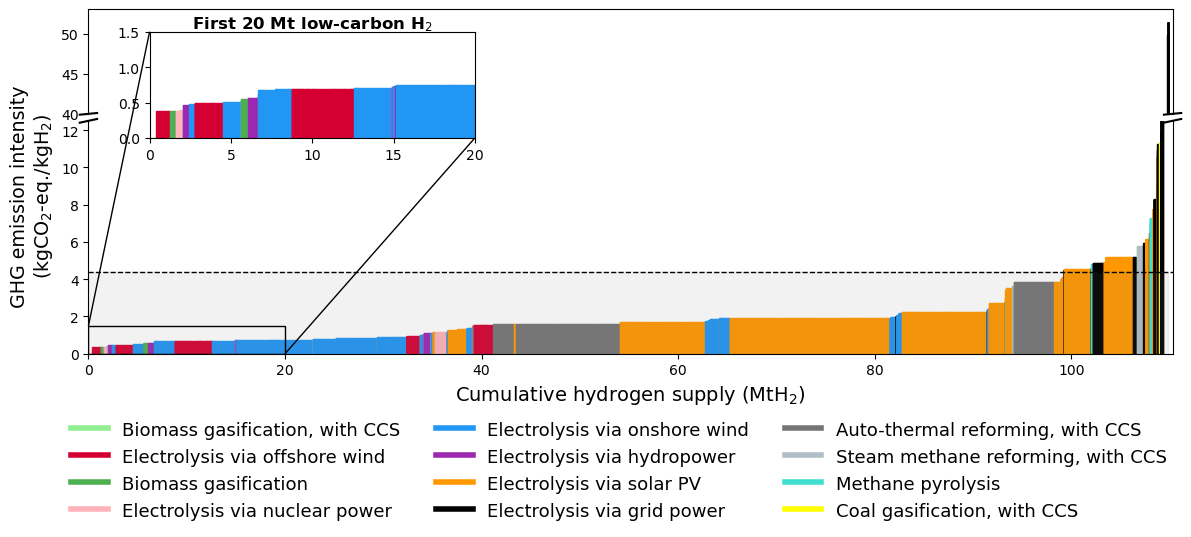

In [28]:
# Define a function to create a colormap for hydrogen production sources
font_size=17

# Sort the DataFrame by 'cc_impact_hydrogen_kg' for correct plotting order
results_df_h2_source = results_df_h2_source.sort_values('lca_impact_h2_climate change')

# Calculate cumulative hydrogen production
results_df_h2_source['cumulative_h2'] = results_df_h2_source['mt_h2'].cumsum()

# Create a new column for the next row's cumulative hydrogen production
results_df_h2_source['next_cumulative_h2'] = results_df_h2_source['cumulative_h2'].shift(-1)

# Get unique hydrogen production sources
unique_sources = results_df_h2_source['new_hydrogen_source_name'].unique()

# Create the plot
fig, ax_main = plt.subplots(figsize=(12, 5))

alpha_s = 1 #alpha of the boxes, but not the sides of the boxes

# Main plot for values up to 20 kgCO2/kgH2
for i, row in results_df_h2_source.iterrows():
    if row['lca_impact_h2_climate change'] <= 20:
        ax_main.fill_betweenx([0, row['lca_impact_h2_climate change']], 
                              row['cumulative_h2'], row['next_cumulative_h2'],
                              color=color_palette.get(row['new_hydrogen_source_name'], '#999999'),
                              alpha=alpha_s)

cut_axis_lim = 12.5
# Set main y-axis limits and add labels
ax_main.set_ylim(0, cut_axis_lim)
ax_main.set_xlim(0, 110.3)
ax_main.set_ylabel('GHG emission intensity\n(kgCO$_2$-eq./kgH$_2$)', fontsize=font_size-3.3, y=0.68)
ax_main.set_xlabel('Cumulative hydrogen supply (MtH$_2$)', fontsize=font_size-3)

# Add secondary axis for values above 20 kgCO2/kgH2
ax_top = ax_main.inset_axes([0, +1.03, 1, 0.45])  # [left, bottom, width, height] in normalized coordinates
ax_top.set_ylim(40, results_df_h2_source['lca_impact_h2_climate change'].max() + 1)
ax_top.set_xlim(ax_main.get_xlim())  # Ensure x-limits match
ax_top.set_xticks([])

# Plot the top section of the supply curve
for i, row in results_df_h2_source.iterrows():
    if row['lca_impact_h2_climate change'] > cut_axis_lim:
        ax_top.fill_betweenx([cut_axis_lim, row['lca_impact_h2_climate change']], 
                             row['cumulative_h2'], row['next_cumulative_h2'],
                             color=color_palette.get(row['new_hydrogen_source_name'], '#999999'),
                             alpha=alpha_s)

# Hide x-ticks for the top axis and add break indicators
ax_main.spines['top'].set_visible(False)
ax_top.spines['bottom'].set_visible(False)

# Diagonal lines to indicate breaks
d = .008
kwargs = dict(transform=ax_main.transAxes, color='k', clip_on=False)
ax_main.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax_main.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax_top.transAxes)
ax_top.plot((-d, +d), (-d, +d), **kwargs)
ax_top.plot((1 - d, 1 + d), (-d, +d), **kwargs)

# Optional: Add emission thresholds or other annotations on the main plot
emission_thresholds = {'Green hydrogen threshold': 4.4}
for label, threshold in emission_thresholds.items():
    ax_main.axhline(y=threshold, color='black', linestyle='--', linewidth=1, label=f'{label} ({threshold} kgCO₂/kgH₂)')
    ax_main.fill_betweenx([0, threshold], 0, results_df_h2_source['cumulative_h2'].max(), color='gray', alpha=0.1)

# Inset for a close-up view of the first 10 Mt
x1, x2, y1, y2 = 0, 20, 0, 1.5
ax_inset = inset_axes(ax_main, width="30%", height="30%", loc='upper left', bbox_to_anchor=(0.05, -0.108, 1, 1.52), bbox_transform=ax_main.transAxes)

for i, row in results_df_h2_source.iterrows():
    if row['cumulative_h2'] <= 20:
        ax_inset.fill_betweenx([0, row['lca_impact_h2_climate change']], 
                               row['cumulative_h2'], row['next_cumulative_h2'],
                               color=color_palette.get(row['new_hydrogen_source_name'], '#999999'),
                               alpha=alpha_s)

ax_inset.set_xlim(x1, x2)
ax_inset.set_ylim(y1, y2)
mark_inset(ax_main, ax_inset, loc1=2, loc2=4, fc="none", ec="black")
ax_inset.set_title('First 20 Mt low-carbon H$_2$', fontsize=font_size-5, fontweight='bold', y=0.95)

ax_inset.grid(color='gray', axis='y', linestyle='--', linewidth=0.5, alpha=0.9)
ax_top.grid(color='gray', axis='y', linestyle='--', linewidth=0.5, alpha=0.9)
ax_main.grid(color='gray', axis='y', linestyle='--', linewidth=0.5, alpha=0.9)

#ax_top.set_title('$\mathbf{o}$ Hydrogen supply curve', 
#                 fontsize=font_size-1, loc='left')

ax_top.grid(False) 
ax_main.grid(False) 
ax_inset.grid(False) 

# Add legend at the bottom with correct color labels
handles = [plt.Line2D([0], [0], color=color_palette[source], lw=4, label=source) for source in unique_sources]
fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.52, -0.23), ncol=3, fontsize=font_size-4, frameon=False)

plt.tight_layout()
plt.savefig("figs/hydrogen_supply_curve.png", dpi=300, bbox_inches='tight')
plt.savefig("figs/pdf/hydrogen_supply_curve.pdf", dpi=300, bbox_inches='tight')
plt.show()

##### Next, will to fill the coordinates for each facility and couple it to a color for the hydrogen pie map charts

In [29]:
dict_criteria = {'kg_h2':'sum',
                'production volume':'sum',
                'decarbonization_potential_Gt':'sum',
                'decarbonization_potential_Gt_low':'sum',
                'decarbonization_potential_tCO2_tH2':'mean',        
                'decarbonization_potential_tCO2_tH2_low':'mean',    
                'lca_impact_climate change':'sum',          
                'lca_impact_ref_climate change':'sum',  
                'lca_impact_ref_low_climate change':'sum',
                                   }

# Load country coordinates
df_countries = pd.read_excel(r'data\df_countries.xlsx', index_col="Country Full")

# Define the coordinates for Taiwan (fallback)
taiwan_lat, taiwan_lon = 23.6978, 120.9605

def get_country_coordinates(country_name):
    """
    Get the latitude and longitude of a country by its name from df_countries.
    Returns (lat, lon) or (None, None) if not found.
    """
    try:
        return df_countries.loc[country_name].lat.item(), df_countries.loc[country_name].lon.item()
    except:
        return None, None

def get_country_name(alpha_2):
    """Convert ISO alpha-2 code to full country name."""
    try:
        return pycountry.countries.get(alpha_2=alpha_2).name
    except:
        return alpha_2

# Aggregate and prepare data
df = results_df.groupby(['Country', 'End product']).agg(dict_criteria).reset_index()
df = df.sort_values(by='decarbonization_potential_Gt_low', ascending=False)
df['decarbonization_potential_Mt'] = df['decarbonization_potential_Gt'] * 1e3
df['decarbonization_potential_Mt_low'] = df['decarbonization_potential_Gt_low'] * 1e3
df = df[['Country', 'End product', 'decarbonization_potential_Mt', 'decarbonization_potential_Mt_low', 'kg_h2']].copy()

# Map country full names and coordinates
df['Country Full'] = df['Country'].apply(get_country_name)
df['lat'], df['lon'] = zip(*df['Country Full'].apply(get_country_coordinates))

# Fill missing values for Taiwan
mask_tw = df['Country'] == 'TW'
df.loc[mask_tw, 'lat'] = df.loc[mask_tw, 'lat'].fillna(taiwan_lat)
df.loc[mask_tw, 'lon'] = df.loc[mask_tw, 'lon'].fillna(taiwan_lon)

# Print any rows still missing coordinates
print(df[df[['lat', 'lon']].isna().any(axis=1)])

# Map colors and compute total hydrogen
df['color'] = df['End product'].map(end_product_colors)
print(df.kg_h2.sum() / 1e9)

Empty DataFrame
Columns: [Country, End product, decarbonization_potential_Mt, decarbonization_potential_Mt_low, kg_h2, Country Full, lat, lon]
Index: []
109.8508704


## 4.2. Generate Figure 5 regarding the emission reduction potentials for both BAU and low-carbon counterfactual scenarios:

In [30]:
def plot_decarbonization_potential_map(df, end_product_colors, output_filepath, threshold=1, leg_pos = (68.08, -8.8)):
    """
    Plot decarbonization potential maps with pie charts and annotations.

    Parameters:
    - df: pd.DataFrame
        DataFrame with columns ['Country Full', 'lat', 'lon', 'End product', 'color', 'decarbonization_potential_Mt', 'decarbonization_potential_Mt_low']
    - end_product_colors: dict
        Dictionary mapping end product names to colors (must correspond to 'color' column in df)
    - output_filepath: str
        File path to save the resulting figure
    """

    fig, axs = plt.subplots(
        nrows=2, ncols=1, figsize=(15, 10),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    plt.subplots_adjust(hspace=0.09)

    for ax, pot_col, title in zip(
        axs,
        ['decarbonization_potential_Mt', 'decarbonization_potential_Mt_low'],
        [r'$\mathbf{a}$ Emission reduction potential: business-as-usual',
         '$\mathbf{b}$ Emission reduction potential: low-carbon']
    ):

        # Add map features
        ax.add_feature(cfeature.LAND, facecolor='#f0f0f0')
        ax.add_feature(cfeature.OCEAN, facecolor='#e0e0e0')
        ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.3)
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='gray')

        # Aggregate data by country
        df_agg = df.groupby('Country Full').agg({
            'lat': 'mean', 'lon': 'mean', pot_col: 'sum'
        }).reset_index()

        # Plot pie charts on map for each country
        for _, row in df_agg.iterrows():
            country_data = df[df['Country Full'] == row['Country Full']]
            if row[pot_col] > threshold:
                grouped_df = country_data.groupby('End product').agg({
                    pot_col: 'sum', 'color': 'first'
                }).reset_index()
                grouped_df = grouped_df[grouped_df[pot_col] > 0]

                pie_ax = inset_axes(
                    ax,
                    width=row[pot_col]/130,
                    height=row[pot_col]/130,
                    loc='center',
                    bbox_to_anchor=(row['lon'], row['lat']),
                    bbox_transform=ax.transData,
                    borderpad=0
                )

                wedges = pie_ax.pie(
                    grouped_df[pot_col],
                    colors=grouped_df['color'],
                    startangle=90,
                    wedgeprops={'linewidth': 0.5, 'edgecolor': 'k'}
                )
                pie_ax.set_aspect('equal')

        # Add country labels with conditions
        for _, row in df_agg.iterrows():
            if (row[pot_col] > 60 if pot_col == 'decarbonization_potential_Mt' else row[pot_col] > 13.5):
                if row["Country Full"] in ["United Kingdom", "Brazil"] and pot_col == 'decarbonization_potential_Mt':
                    ax.text(
                        row['lon'], row['lat'] + 17,
                        f"{row['Country Full']}:\n {int(round(row[pot_col], 0))} Mt/a",
                        fontsize=9, ha='center', va='center', zorder=1000,
                        color='black',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3')
                    )
                elif row["Country Full"] == "China" and pot_col == 'decarbonization_potential_Mt':
                    ax.text(
                        row['lon'] + 6, row['lat'] - (row[pot_col]**0.92 / 3.43),
                        f"{row['Country Full']}: {int(round(row[pot_col], 0))} Mt/a",
                        fontsize=9, ha='center', va='center', zorder=1000,
                        color='black',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3')
                    )
                elif pot_col == 'decarbonization_potential_Mt':
                    ax.text(
                        row['lon'] + 2, row['lat'] - (row[pot_col]**0.90 / 3.43),
                        f"{row['Country Full']}: {int(round(row[pot_col], 0))} Mt/a",
                        fontsize=9, ha='center', va='center', zorder=1000,
                        color='black',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3')
                    )
                else:
                    ax.text(
                        row['lon'] + 2, row['lat'] - 7,
                        f"{row['Country Full']}: {int(round(row[pot_col], 0))} Mt/a",
                        fontsize=9, ha='center', va='center', zorder=1000,
                        color='black',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3')
                    )

        ax.set_title(title, fontsize=14, loc='left')

        # Add inset pie chart summarizing end product share
        grouped_df = df.groupby('End product').agg({pot_col: 'sum', 'color': 'first'}).reset_index()
        grouped_df = grouped_df[grouped_df[pot_col] >= 0]

        ax_inset = inset_axes(
            ax, width=1.2, height=1.2,
            bbox_to_anchor=(0.94, 0.94, 0.058, 0.058),
            bbox_transform=ax.transAxes,
            borderpad=0
        )

        wedges, texts, autotexts = ax_inset.pie(
            grouped_df[pot_col],
            labels=None,
            colors=grouped_df['color'],
            autopct=lambda pct: custom_autopct(pct, grouped_df[pot_col]),
            startangle=90,
            wedgeprops={'linewidth': 0.8, 'edgecolor': 'black'},
            pctdistance=0.56
        )
        plt.setp(autotexts, size=6, color="white", weight='bold')
        ax_inset.set_title(f'Total: {df_agg[pot_col].sum():.0f} Mt', fontsize=8.1, weight='bold', y=0.850)

        # Add a translucent rectangle behind the pie inset
        rect = patches.Rectangle(
                (0.84, 0.69), 0.2, 0.6,
                transform=ax.transAxes,
                facecolor=(0, 0, 0, 0.1),   # black with 10% opacity
                edgecolor=(0, 0, 0, 0.5),     # solid black border
                linewidth=1
            )
        ax.add_patch(rect)
        
        # ========== EUROPEAN ZOOM INSET ==========
        # European extent coordinates
        # Add zoomed-in inset for Europe
        # Add Europe inset map in bottom-left
        europe_ax = inset_axes(
            ax,
            width="30%", height="42%",  # relative to parent
            loc='lower left',
            bbox_to_anchor=(-0.0535, -0.015, 1, 1),
            bbox_transform=ax.transAxes,
            axes_class=cartopy.mpl.geoaxes.GeoAxes,
            axes_kwargs=dict(projection=ccrs.PlateCarree()),
            #borderpad=1.5
        )
    
        zoom_extent = [-10, 28, 32, 70] # [lon_min, lon_max, lat_min, lat_max]
        europe_ax.set_extent(zoom_extent, crs=ccrs.PlateCarree())
        europe_ax.add_feature(cfeature.LAND, facecolor='#f0f0f0')
        europe_ax.add_feature(cfeature.OCEAN, facecolor='#e0e0e0')
        europe_ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.3)
        europe_ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='gray')
        europe_ax.set_title("Europe", fontsize=8, loc='left', weight='bold')
    
        mark_inset(ax, europe_ax, loc1=2, loc2=4, fc="none", ec='darkgray', linestyle='')
        # Then access the connecting lines and hide them
        for line in ax.patches[-1].get_children():
            if hasattr(line, 'set_visible'):
                line.set_visible(False)

        # Aggregate data by country
        df_agg = df.groupby('Country Full').agg({
            'lat': 'mean', 'lon': 'mean', pot_col: 'sum'
        }).reset_index()
        
        # Plot pies in the Europe inset
        for _, row in df_agg.iterrows():
            if zoom_extent[0] <= row['lon'] <= zoom_extent[1] and zoom_extent[2] <= row['lat'] <= zoom_extent[3]:  # Filter only Europe
                country_data = df[df['Country Full'] == row['Country Full']]
                if row[pot_col] > threshold:
                    grouped_df = country_data.groupby('End product').agg({
                        pot_col: 'sum', 'color': 'first'
                    }).reset_index()
                    grouped_df = grouped_df[grouped_df[pot_col] > 0]
    
                    pie_ax = inset_axes(
                        europe_ax,
                        width=row[pot_col]/130,
                        height=row[pot_col]/130,
                        loc='center',
                        bbox_to_anchor=(row['lon'], row['lat']),
                        bbox_transform=europe_ax.transData,
                        borderpad=0
                    )
    
                    wedges = pie_ax.pie(
                        grouped_df[pot_col],
                        colors=grouped_df['color'],
                        startangle=90,
                        wedgeprops={'linewidth': 0.5, 'edgecolor': 'k'}
                    )
                    pie_ax.set_aspect('equal')
                    
    # Legend creation
    legend_patches = [
        mpatches.Patch(color=color,
                       label=label.replace('H2', 'H$_2$').replace('CH4', 'CH$_4$'))
        for label, color in end_product_colors.items()
    ]

    size_legend = [mlines.Line2D([], [], marker='o', color='white',
                                markerfacecolor='gray', markersize=size,
                                label=f'{int(size * 2)} Mt') for size in [6.25, 12.5, 25]]

    size_legend = [mlines.Line2D([], [], marker='', color='white', markersize=0, label='')] + size_legend

    all_legend_patches = legend_patches + size_legend
    plt.legend(handles=all_legend_patches, bbox_to_anchor=leg_pos, ncol=6, fontsize=9, frameon=False)

    # Set visible frames on the maps
    for ax in axs.flatten():
        ax.spines['geo'].set_visible(True)
        ax.spines['geo'].set_linewidth(1.5)
        ax.spines['geo'].set_color('gray')

    # Save and show
    plt.savefig(output_filepath, dpi=300, bbox_inches='tight')
    if '.png' in str(output_filepath):
        plt.savefig(output_filepath.replace('figs/', 'figs/pdf/').replace('.png', '.pdf'), dpi=300, bbox_inches='tight')
    plt.show()

C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


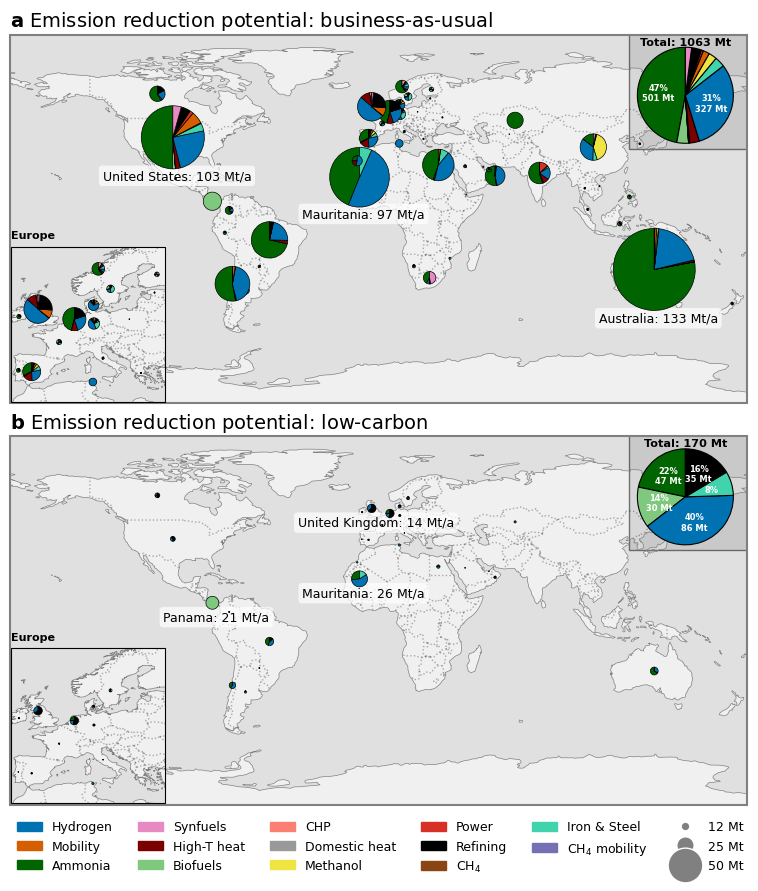

In [31]:
plot_decarbonization_potential_map(
    df=df,
    end_product_colors=end_product_colors,
    output_filepath="figs/decarbonization_potential_map.png"
)

## 4.3. Generate the figure (Figure 1b) regarding planned initiatives for hydrogen applications worldwide on a map with a country-specific pie charts:

C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


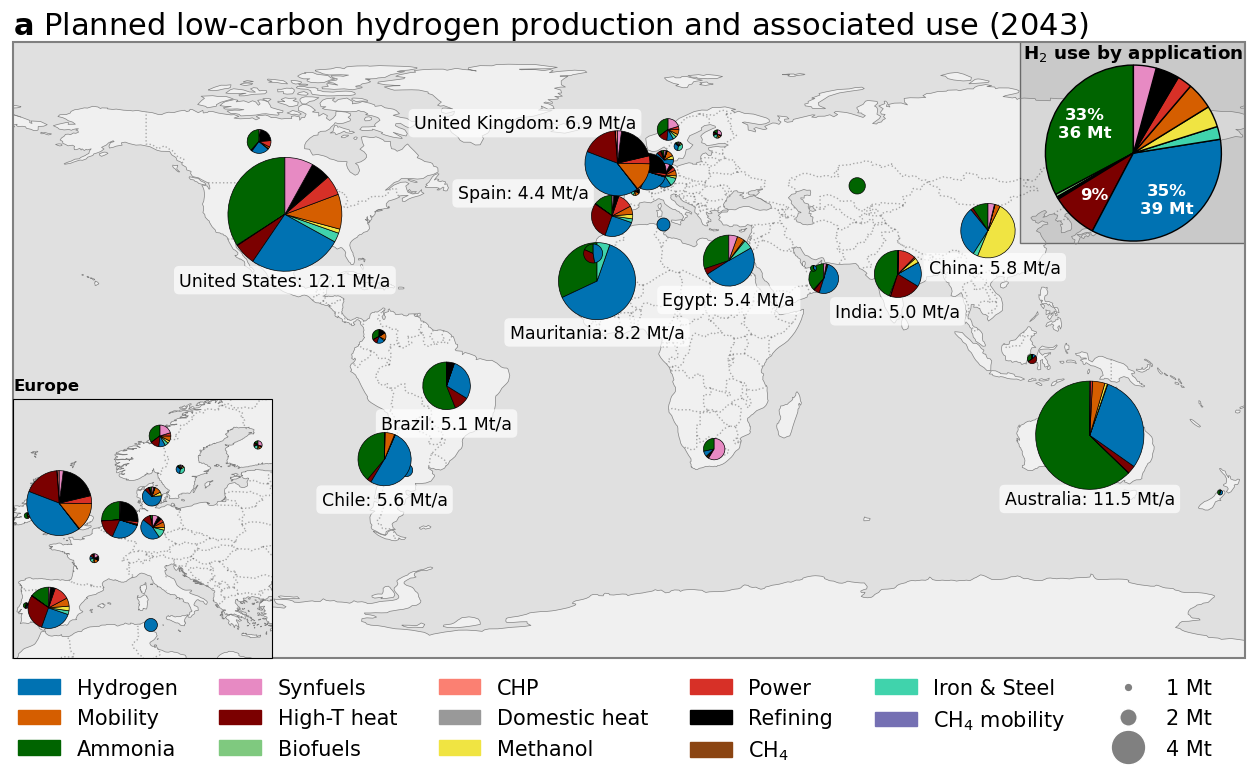

In [32]:
plot_hydrogen_pie_map(df, end_product_colors)

## 4.3.1. Generate the figure (Figure in the SI) country-specific hydrogen mixes for the SI:

C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


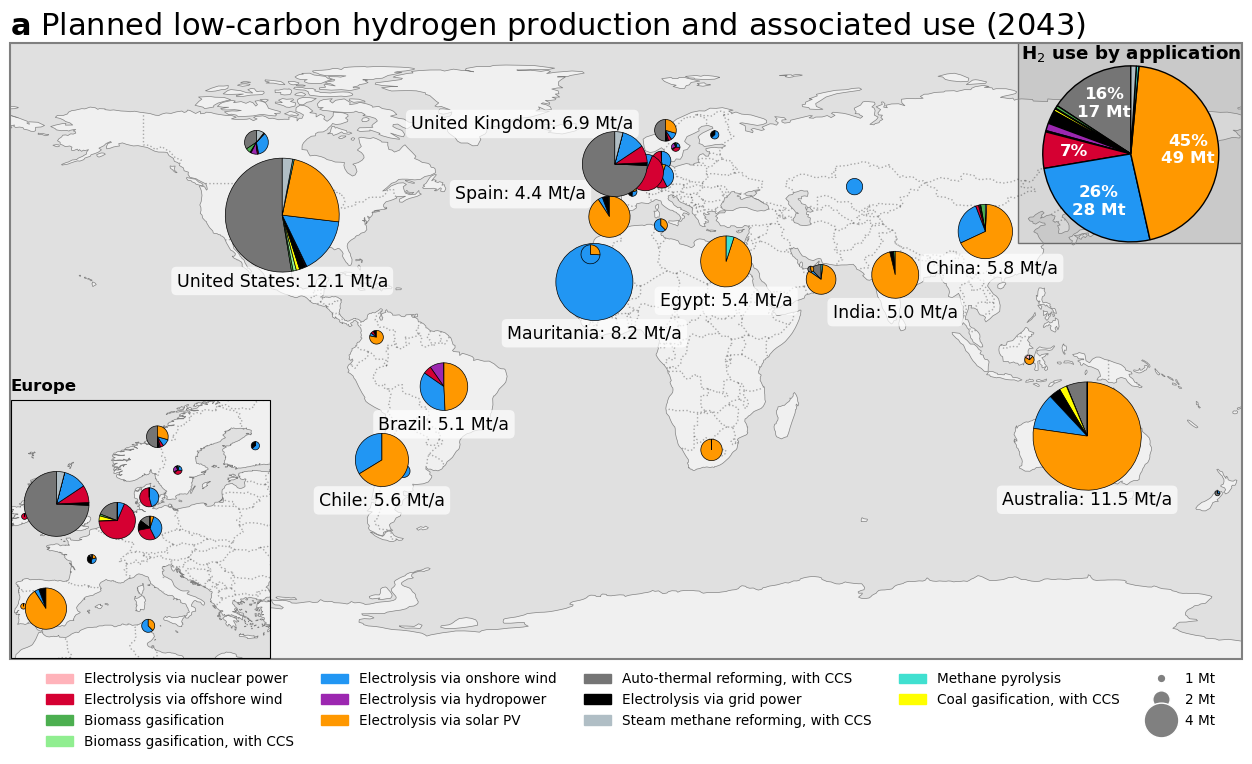

In [33]:
# Group and aggregate
agg_df = results_df.groupby(['Country', 'new_hydrogen_source_name']).agg(dict_criteria).reset_index()

# Sort and compute decarbonization in Mt
agg_df = agg_df.sort_values(by='decarbonization_potential_Gt_low', ascending=False)
agg_df['decarbonization_potential_Mt'] = agg_df['decarbonization_potential_Gt'] * 1e3
agg_df['decarbonization_potential_Mt_low'] = agg_df['decarbonization_potential_Gt_low'] * 1e3

# Select relevant columns
df = agg_df[['Country', 'new_hydrogen_source_name', 'decarbonization_potential_Mt', 
             'decarbonization_potential_Mt_low', 'kg_h2']].copy()

# Enrich with country names and coordinates
df['Country Full'] = df['Country'].apply(get_country_name)
df[['lat', 'lon']] = df['Country Full'].apply(get_country_coordinates).apply(pd.Series)

# Fill missing Taiwan coordinates if necessary
df.loc[(df['Country'] == 'TW') & df['lat'].isna(), 'lat'] = taiwan_lat
df.loc[(df['Country'] == 'TW') & df['lon'].isna(), 'lon'] = taiwan_lon

# Print any remaining missing coordinates
missing_coords = df[df[['lat', 'lon']].isna().any(axis=1)]
if not missing_coords.empty:
    print(missing_coords)

# Map colors and plot
df['color'] = df['new_hydrogen_source_name'].map(color_palette)
#plot hydrogen mixes map:
plot_hydrogen_pie_map(df, color_palette, groupeby='new_hydrogen_source_name', font_size_leg=9.8, leg_cols=5, 
                      output_path="figs/h2_prod_map_source_mixes.png")

### Now, before plotting the violin plots, first, get the average climate impacts for this figure:

In [34]:
results_df_wo_ff = results_df.copy()
agg_df = results_df_wo_ff.groupby('End product').agg(dict_criteria)#.sort_values(by='decarbonization_potential_tCO2_tH2', ascending=False)
agg_df.decarbonization_potential_tCO2_tH2_low = (agg_df.decarbonization_potential_Gt_low * 1e9)	/ (agg_df.kg_h2 /1e3)
agg_df.decarbonization_potential_tCO2_tH2 = (agg_df.decarbonization_potential_Gt * 1e9)	/ (agg_df.kg_h2 /1e3)

agg_df['lca_impact_climate change_unit_ref'] = (agg_df['lca_impact_ref_climate change']) / (agg_df['production volume'])
agg_df['lca_impact_climate change_unit_ref_low'] = (agg_df['lca_impact_ref_low_climate change']) / (agg_df['production volume'])
agg_df

,kg_h2,production volume,decarbonization_potential_Gt,decarbonization_potential_Gt_low,decarbonization_potential_tCO2_tH2,decarbonization_potential_tCO2_tH2_low,lca_impact_climate change,lca_impact_ref_climate change,lca_impact_ref_low_climate change,lca_impact_climate change_unit_ref,lca_impact_climate change_unit_ref_low
End product,,,,,,,,,,,
Ammonia,3.601626e+10,2.046378e+11,0.500765,0.046687,13.903872,1.296268,1.655421e+11,6.663075e+11,2.122288e+11,3.256033,1.037094
Biofuels,5.731141e+08,1.364557e+10,0.042192,0.029568,73.618073,51.592242,4.227700e+09,4.641926e+10,3.379594e+10,3.401781,2.476696
CH4,1.272094e+08,2.553448e+08,-0.000106,-0.000845,-0.836529,-6.642870,9.776203e+08,8.712059e+08,1.325845e+08,3.411880,0.519237
CH4 mobility,4.095500e+07,1.757911e+09,0.000138,-0.000140,3.372190,-3.421916,3.652007e+08,5.033088e+08,2.250561e+08,0.286311,0.128025
CHP,1.961970e+08,1.165851e+11,0.003192,-0.000111,16.268134,-0.565855,8.322076e+08,4.023967e+09,7.211885e+08,0.034515,0.006186
Domestic heat,1.343611e+08,1.768558e+10,0.001000,-0.000173,7.445892,-1.289165,3.511215e+08,1.351560e+09,1.779078e+08,0.076422,0.010059
High-T heat,9.361842e+09,1.057311e+12,0.034273,-0.012633,3.660929,-1.349409,2.264597e+10,5.691900e+10,1.001302e+10,0.053834,0.009470
Hydrogen,3.870834e+10,3.870834e+10,0.327142,0.085907,8.451466,2.219338,6.606364e+10,3.932058e+11,1.519705e+11,10.158169,3.926041
Iron & Steel,2.594277e+09,3.873028e+10,0.036986,0.017395,14.256744,6.705048,5.019819e+10,8.718414e+10,6.759294e+10,2.251059,1.745222


## 4.4. Generate the figure (Figure 2a-n) regarding the violin plots per hydrogen application

In [35]:
# Calculate the impact per FU end product
results_df_wo_ff['lca_impact_climate change_unit'] = (
    results_df_wo_ff['lca_impact_climate change'] / results_df_wo_ff['production volume']
)
results_df_wo_ff['lca_impact_climate change_unit_ref'] = (
    results_df_wo_ff['lca_impact_ref_climate change'] / results_df_wo_ff['production volume']
)
results_df_wo_ff['lca_impact_climate change_unit_ref_low'] = (
    results_df_wo_ff['lca_impact_ref_low_climate change'] / results_df_wo_ff['production volume']
)


### 4.4.1 with and without impact of hydrogen within application

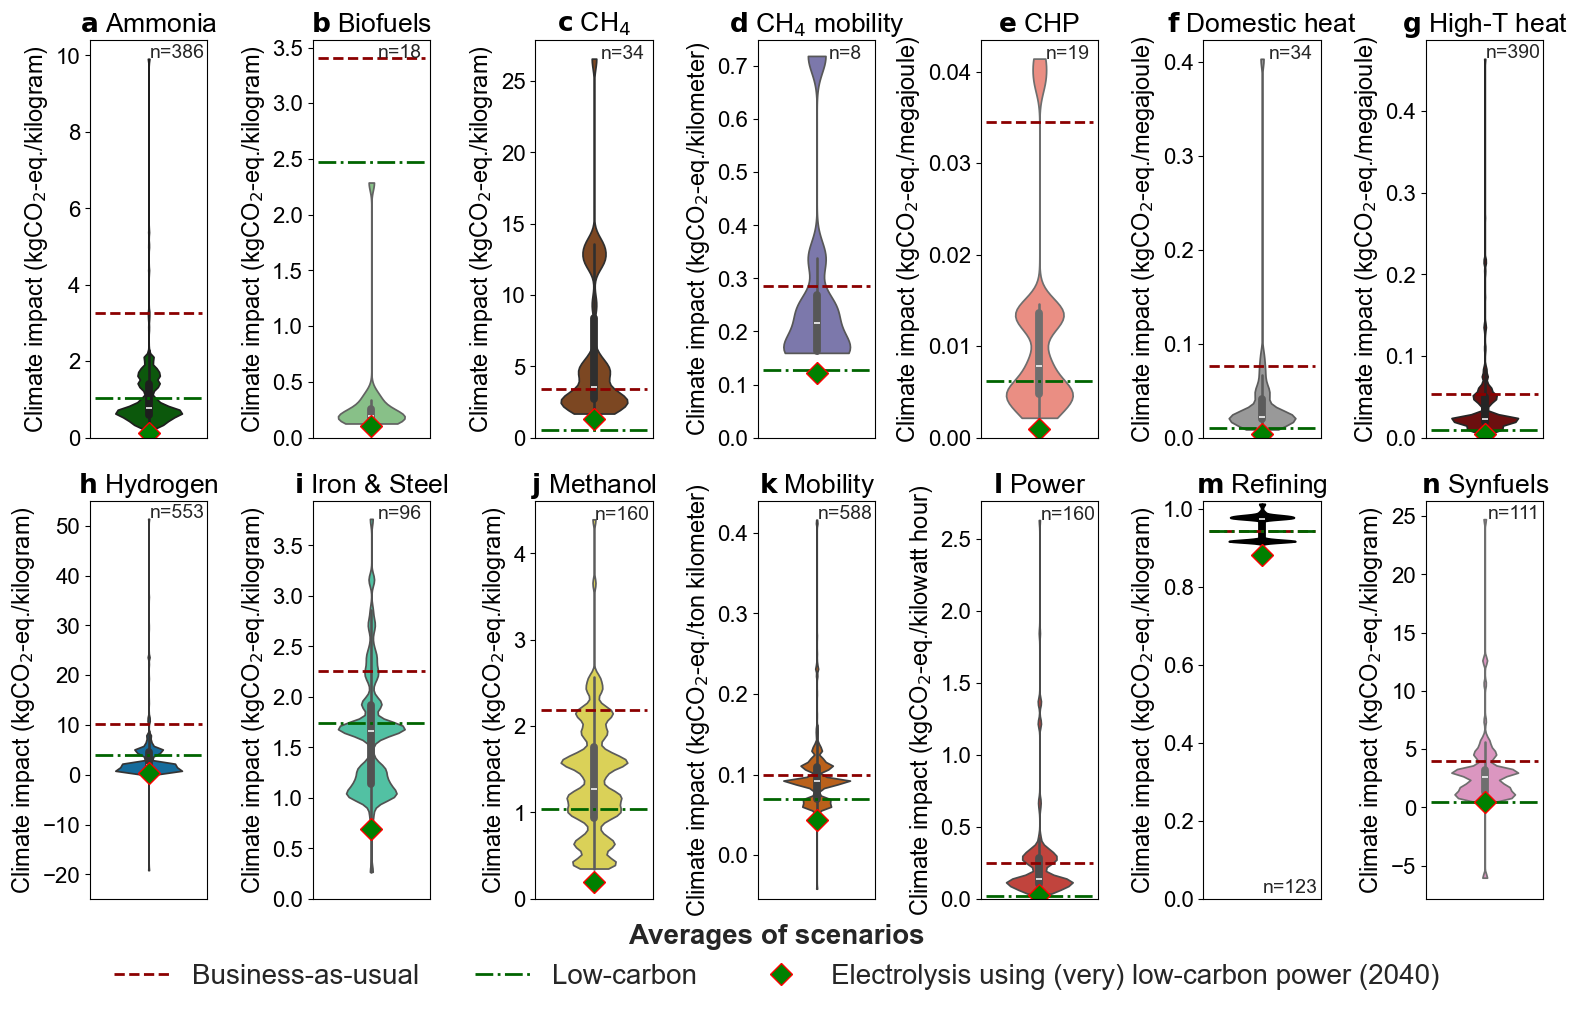

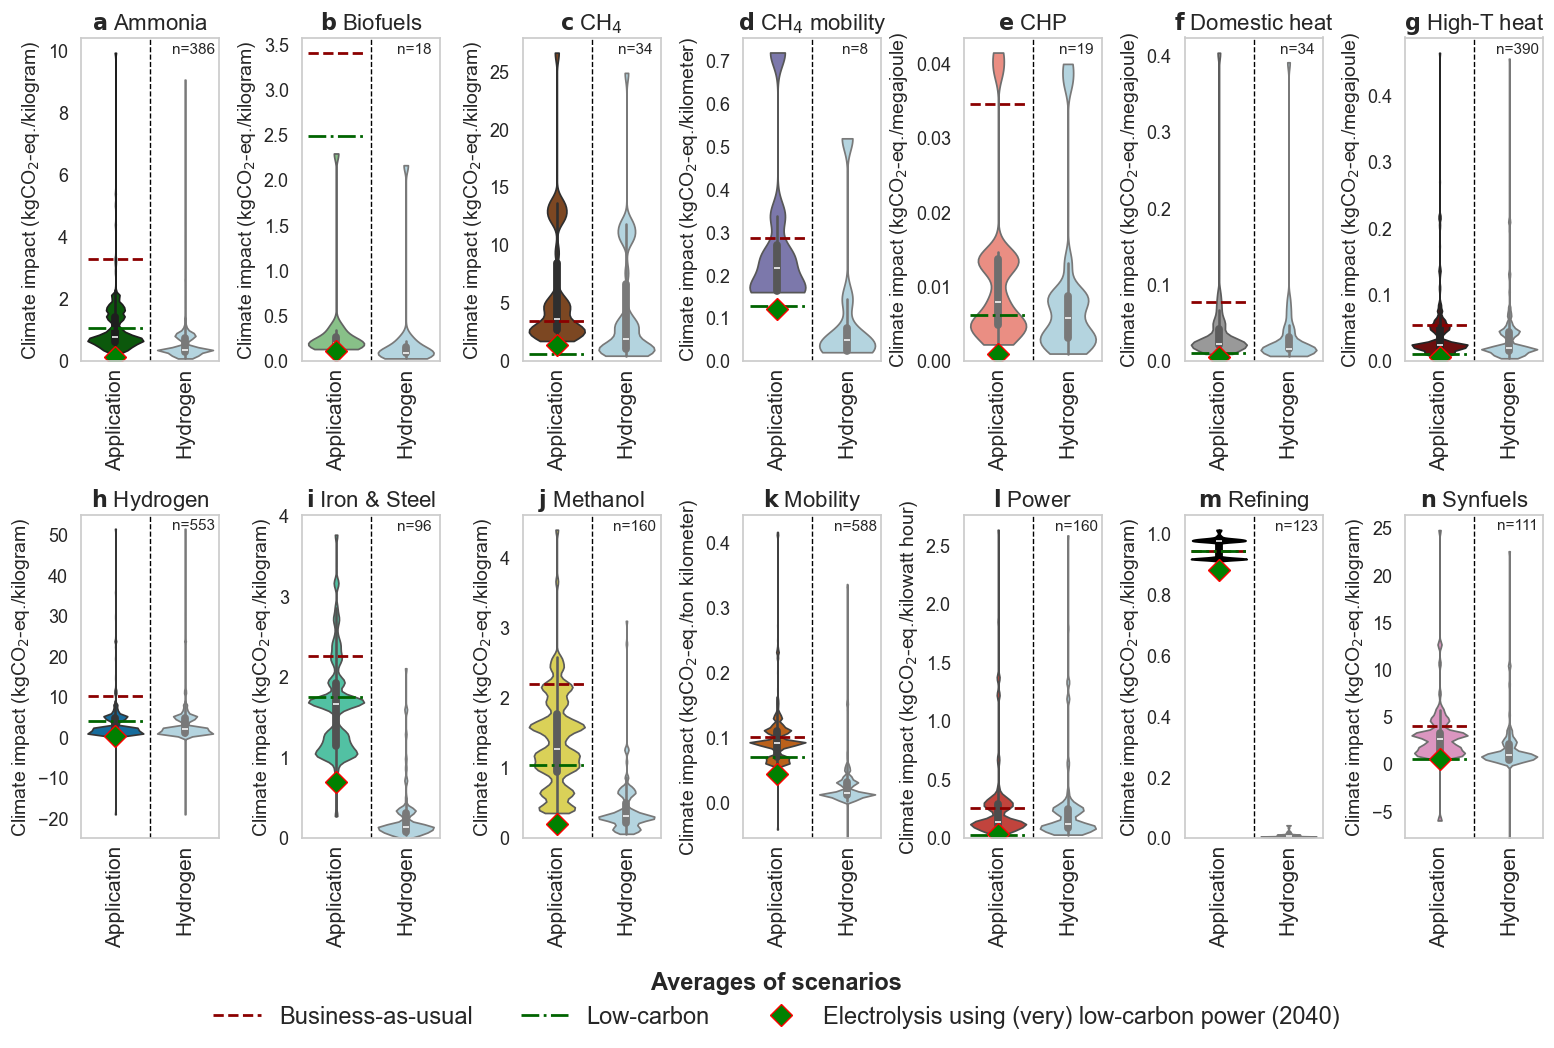

In [36]:
# List of unique end products
end_products = results_df_wo_ff['End product'].unique()

# Mapping of scenario names
scenario_labels = {
    'lca_impact_climate change_unit': 'Result',
    'lca_impact_climate change_unit_ref': 'Business-as-usual',
    'lca_impact_climate change_unit_ref_low': 'Low-carbon'
}

for font_size, show_h2_impact, height_plot in zip([20,17], [False, True], [11.3,12]):
    plot_violin_end_products(
        results_df=results_df_wo_ff,
        agg_df=agg_df,
        end_products=end_products,
        scenario_labels=scenario_labels,
        end_product_colors=end_product_colors,
        calculate_lca_impact=calculate_lca_impact,
        MY_METHODS=MY_METHODS,
        new_db_name_low_acts=new_db_name_low_acts,
        hydrogen_impact=show_h2_impact,
        height_plot = height_plot,
        font_size = font_size,
        output_path=f'figs/violinplot_end_products_cc_{show_h2_impact}.png'
    )

## 4.5. Generate the figure (Figure 3) regarding the mission reduction potential per application in boxplots for both scenarios 

C:\Users\terlouw_t\Documents\Projects\TRANSIENCE\hydrogen_applications\generate_figures.py:491: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Scenario', y='Decarbonization Potential', data=df_prod,
C:\Users\terlouw_t\Documents\Projects\TRANSIENCE\hydrogen_applications\generate_figures.py:496: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(scenario_map.values()), rotation=90, ha='center', fontsize=font_size - 3)
C:\Users\terlouw_t\Documents\Projects\TRANSIENCE\hydrogen_applications\generate_figures.py:458: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Scenario', y='Decarbonizatio

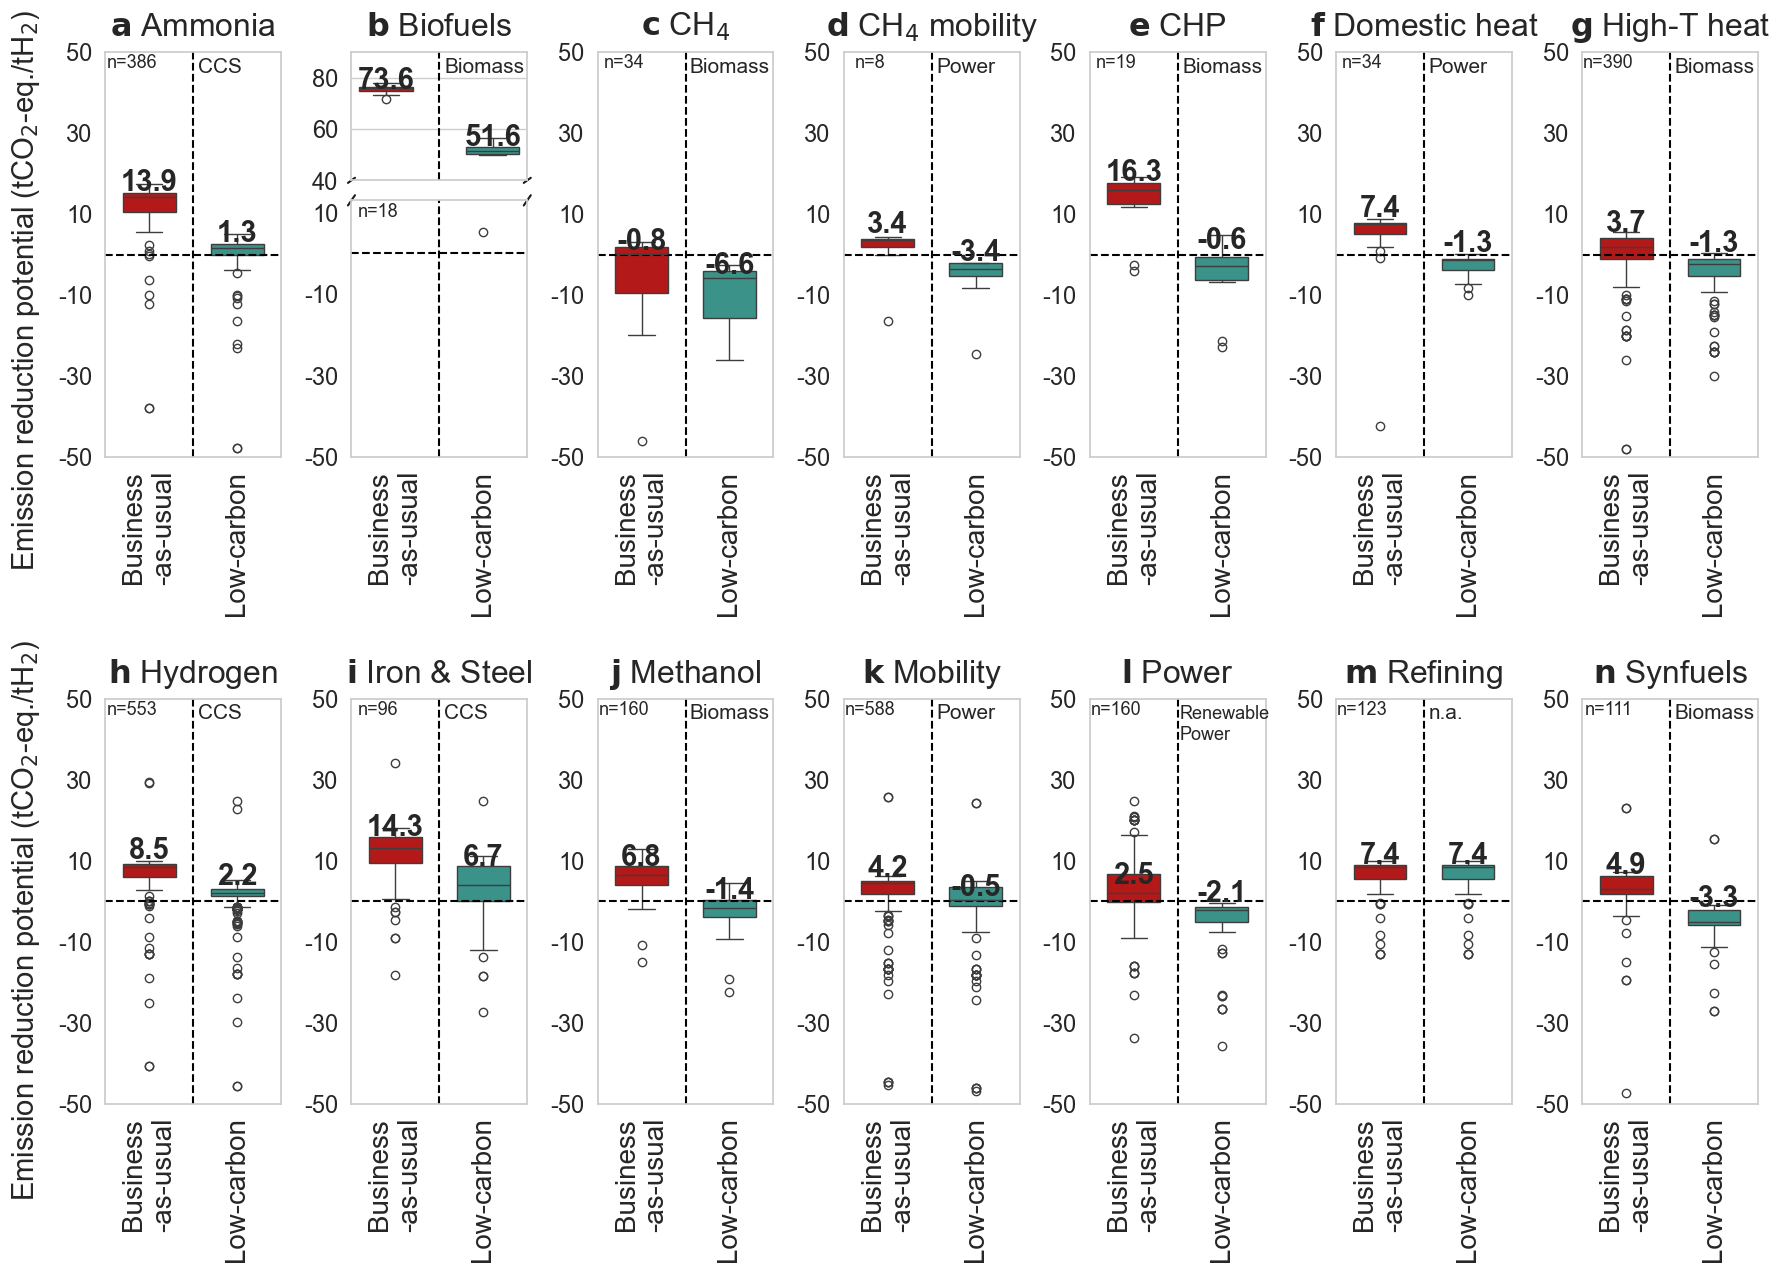

In [38]:
plot_decarbonization_potential_boxplots(results_df_wo_ff, agg_df, replace_low_carbon_product)

## 4.6. Estimate biomass requirements for a short discussion in the results section on limited resource for applications and synfuels: 

In [39]:
# Energy density sources:
energy_density_wood_chips = 19  # MJ/kg dry wood chips 
# Source: https://www.engineeringtoolbox.com/wood-biomass-combustion-heat-d_440.html

energy_density_biomethane = 36  # MJ/m³ biomethane 
# Source: https://www.iea.org/reports/outlook-for-biogas-and-biomethane-prospects-for-organic-growth/an-introduction-to-biogas-and-biomethane

# Synfuels: energy from wood chips per kg kerosene equivalent
# 1. syngas, RWGS, Production 
# 2. hydrogen production, gaseous, 25 bar, from gasification of woody biomass in entrained flow gasifier, at gasification plant
# 3. wood chips, wet, measured as dry mass
kg_wood_per_kg_synfuel = 2.35 * 0.125 * 11.6966
synfuels_mj = energy_density_wood_chips * kg_wood_per_kg_synfuel

# High-T heat and CHP: kg wood chips per MJ heat (wet, measured as dry mass)
kg_wood_per_mj_heat = 0.039572155621690024 + 8.96613161529328e-05
high_t_heat_mj = energy_density_wood_chips * kg_wood_per_mj_heat

# Methanol:
# syngas: 7.1255 kg/kg methanol
# Biomass split into 2 equal groups with various types of wood chips (dry and wet)
group1 = sum([
    0.09934496,              # wood chips, dry, measured as dry mass
    0.3515836141987803,      # wood chips, wet, measured as dry mass
    0.0007966068335582196,   # wood chips, wet, measured as dry mass
    0.007178166967661481     # wood chips, wet, measured as dry mass
])
group2 = sum([
    0.10258638,              # wood chips, dry, measured as dry mass
    0.3630563896716083,      # wood chips, wet, measured as dry mass
    0.0008226014788500979,   # wood chips, wet, measured as dry mass
    0.0074124028495416005    # wood chips, wet, measured as dry mass
])
kg_wood_per_kg_methanol = 7.1255 * 0.5 * (group1 + group2)
methanol_mj = energy_density_wood_chips * kg_wood_per_kg_methanol

# CH4: biomethane volume required per MJ
# Based on cubic meter biomethane per MJ CH4
biomethane_m3_per_mj = sum([
    0.57051339417427,
    0.0134657388881088,
    0.261368205212843,
    0.154572594480714,
    8.00672440648118e-05
])
ch4_mj = energy_density_biomethane * biomethane_m3_per_mj  # MJ per MJ CH4 (unit cancels to MJ biomass input per MJ CH4)

# Final biomass demand in MJ per kg or MJ of end product
low_carbon_product_biomass_amount_mj = {
    'Hydrogen': 0,         
    'Mobility': 0,    
    'Ammonia': 0,    
    'Synfuels': synfuels_mj,
    'High-T heat': high_t_heat_mj,
    'Biofuels': 44,  # MJ/kg biofuel.  
    'CHP': high_t_heat_mj,
    'Domestic heat': 0,
    'Methanol': methanol_mj,
    'Power': 0,   
    'Refining': 0,  
    'CH4': ch4_mj,
    'Iron & Steel': 0, 
    'CH4 mobility': 0, 
}
low_carbon_product_biomass_amount_mj

{'Hydrogen': 0,
 'Mobility': 0,
 'Ammonia': 0,
 'Synfuels': 65.28164875,
 'High-T heat': 0.7535745218190162,
 'Biofuels': 44,
 'CHP': 0.7535745218190162,
 'Domestic heat': 0,
 'Methanol': 63.14205290570449,
 'Power': 0,
 'Refining': 0,
 'CH4': 36.00000000000002,
 'Iron & Steel': 0,
 'CH4 mobility': 0}

In [40]:
# Conversion factor and total global biomass availability (IEA estimate)
MJ_TO_EJ = 1e-12
BIOMASS_WORLD_EJ = 67  # EJ/year, from IEA

# Prepare biomass use data
agg_df_biomass = (
    agg_df[['kg_h2', 'production volume']]
    .copy()
    .reset_index()
)

# Map biomass intensity (MJ/kg product) and compute total biomass demand
agg_df_biomass['specific_biomass_mj'] = agg_df_biomass['End product'].map(low_carbon_product_biomass_amount_mj)
agg_df_biomass['total_biomass_mj'] = agg_df_biomass['specific_biomass_mj'] * agg_df_biomass['production volume']
agg_df_biomass['total_biomass_ej'] = agg_df_biomass['total_biomass_mj'] * MJ_TO_EJ

# Calculate total biomass used and share of global availability
total_biomass_ej = agg_df_biomass['total_biomass_ej'].sum()
biomass_share = total_biomass_ej / BIOMASS_WORLD_EJ

# Print result
print(f"Total biomass used: {total_biomass_ej:.2f} EJ")
print(f"Share of world biomass availability used: {biomass_share:.2%}")
agg_df_biomass

Total biomass used: 4.13 EJ
Share of world biomass availability used: 6.16%


,End product,kg_h2,production volume,specific_biomass_mj,total_biomass_mj,total_biomass_ej
0,Ammonia,3.601626e+10,2.046378e+11,0.000000,0.000000e+00,0.000000
1,Biofuels,5.731141e+08,1.364557e+10,44.000000,6.004053e+11,0.600405
2,CH4,1.272094e+08,2.553448e+08,36.000000,9.192414e+09,0.009192
3,CH4 mobility,4.095500e+07,1.757911e+09,0.000000,0.000000e+00,0.000000
4,CHP,1.961970e+08,1.165851e+11,0.753575,8.785553e+10,0.087856
5,Domestic heat,1.343611e+08,1.768558e+10,0.000000,0.000000e+00,0.000000
6,High-T heat,9.361842e+09,1.057311e+12,0.753575,7.967628e+11,0.796763
7,Hydrogen,3.870834e+10,3.870834e+10,0.000000,0.000000e+00,0.000000
8,Iron & Steel,2.594277e+09,3.873028e+10,0.000000,0.000000e+00,0.000000
9,Methanol,4.294646e+09,3.090218e+10,63.142053,1.951227e+12,1.951227


In [41]:
# Constants
MJ_TO_EJ = 1e-12
KEROSENE_FUTURE_EJ = 15      # Future kerosene demand in EJ/year
ENERGY_DENSITY_SAF = 42      # MJ/kg synthetic kerosene

# Calculate required synthetic kerosene in kg
kg_synthetic_kerosene = KEROSENE_FUTURE_EJ / (ENERGY_DENSITY_SAF * MJ_TO_EJ)

# Get biomass intensity (MJ/kg) for synfuels from earlier dataframe
biomass_intensity_synfuel = agg_df_biomass.loc[
    agg_df_biomass['End product'] == 'Synfuels',
    'specific_biomass_mj'
].item()

# Calculate total biomass required in EJ
total_biomass_ej = kg_synthetic_kerosene * biomass_intensity_synfuel * MJ_TO_EJ

# Share of global biomass availability
biomass_share = total_biomass_ej / BIOMASS_WORLD_EJ

# Print results
print(f"Biomass needed for synthetic kerosene: {total_biomass_ej:.2f} EJ")
print(f"Share of global biomass availability: {biomass_share:.2%}")

Biomass needed for synthetic kerosene: 23.31 EJ
Share of global biomass availability: 34.80%


##### Next, remove refining, and end product fossil fuels here

In [42]:
results_df_wo_ff = results_df_wo_ff.loc[results_df_wo_ff['Reference_Product'] !='fossil fuel']
results_df_wo_ff

,Name,Year,Country,Database,End product,production volume,Unit,Reference_Product,Facility_key,Activity_Name_prod,...,decarbonization_potential_Gt,decarbonization_potential_tCO2_tH2,decarbonization_potential_Gt_low,decarbonization_potential_tCO2_tH2_low,lca_impact_h2_total,lca_impact_h2_spec,new_hydrogen_source_name,lca_impact_climate change_unit,lca_impact_climate change_unit_ref,lca_impact_climate change_unit_ref_low
1339,H2 facility 'BENORTH2 (Amorebieta-Boroa power ...,2025,ES,ecoinvent_310_reference,Hydrogen,6.583627e+05,kilogram,"hydrogen, gaseous, 30 bar","(iea_facility_db_regionalized, ddb9649bba69420...",nan,...,-8.437019e-07,-1.281517,-4.011622e-06,-6.093338,7.832851e+06,11.897471,Electrolysis via grid power,11.897483,10.615967,5.804151
936,H2 facility 'White Martins Pernambuco' (2022) ...,2025,BR,ecoinvent_310_reference,Hydrogen,4.680000e+04,kilogram,"hydrogen, gaseous, 30 bar","(iea_facility_db_regionalized, ab9c1f77df0a41e...",nan,...,2.840028e-07,6.068436,5.880979e-08,1.256619,2.128245e+05,4.547532,Electrolysis via solar PV,4.547532,10.615967,5.804151
935,H2 facility 'HPCL Vizag Refinery H2' (2024) [2...,2025,IN,ecoinvent_310_reference,High-T heat,1.174017e+07,megajoule,"heat production, from hydrogen-fired one gigaw...","(iea_facility_db_regionalized, 50de38f98e4149a...","heat production, from hydrogen-fired one gigaw...",...,-2.425447e-07,-2.333237,-6.631542e-07,-6.379427,5.380758e+05,0.045832,Electrolysis via solar PV,0.059528,0.038868,0.003042
2062,H2 facility 'Power plant in Lebanon for a Powe...,2025,LB,ecoinvent_310_reference,Power,2.193702e+05,kilowatt hour,"electricity production, from hydrogen-fired on...","(iea_facility_db_regionalized, 043e8abeaa41470...","electricity production, from hydrogen-fired on...",...,1.450592e-07,13.171630,-6.181275e-08,-5.612708,5.700544e+04,0.259859,Electrolysis via solar PV,0.316865,0.978117,0.035091
933,H2 facility 'H2 Energy Europe Esbjerg green hy...,2025,DK,ecoinvent_310_reference,Mobility,6.387495e+09,ton kilometer,"transport, freight, lorry, fuel cell electric,...","(iea_facility_db_regionalized, a43d04c2be4f462...","transport, freight, lorry, fuel cell electric,...",...,2.211190e-04,5.362937,1.618739e-04,3.926028,6.400212e+07,0.010020,Electrolysis via offshore wind,0.089247,0.123865,0.114590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1870,H2 facility 'Madhya Pradesh H2' (2040) [1/5] w...,2040,IN,ecoinvent_remind_SSP2-PkBudg1150_2040_base,High-T heat,3.711155e+05,megajoule,"heat production, from hydrogen-fired one gigaw...","(iea_facility_db_regionalized, 7183f7f7dde6488...","heat production, from hydrogen-fired one gigaw...",...,1.579070e-08,4.805449,-1.111715e-09,-0.338319,3.752609e+03,0.010112,Electrolysis via solar PV,0.012530,0.055080,0.009535
1808,H2 facility 'Madhya Pradesh H2' (2040) [5/5] w...,2040,IN,ecoinvent_remind_SSP2-PkBudg1150_2040_base,CHP,1.952622e+06,megajoule,"heat, residential, by combustion of hydrogen u...","(iea_facility_db_regionalized, a0dfe788457a4f4...","heat, residential, by combustion of hydrogen u...",...,6.240109e-08,18.989984,1.395703e-08,4.247422,3.752609e+03,0.001922,Electrolysis via solar PV,0.002387,0.034345,0.009535
1275,H2 facility 'Madhya Pradesh H2' (2040) [2/5] w...,2040,IN,ecoinvent_remind_SSP2-PkBudg1150_2040_base,Mobility,5.090667e+05,ton kilometer,"transport, freight, lorry, fuel cell electric,...","(iea_facility_db_regionalized, 9cbf327e2461418...","transport, freight, lorry, fuel cell electric,...",...,1.235369e-08,3.759492,-4.155595e-09,-1.264636,3.752609e+03,0.007372,Electrolysis via solar PV,0.049503,0.073770,0.041339
548,H2 facility 'Madhya Pradesh H2' (2040) [3/5] w...,2040,IN,ecoinvent_remind_SSP2-PkBudg1150_2040_base,Power,6.545296e+04,kilowatt hour,"electricity production, from hydrogen-fired on...","(iea_facility_db_regionalized, ef9f7825b8be4ec...","electricity production, from hydrogen-fired on...",...,-1.658580e-09,-0.504741,-3.856886e-09,-1.173733,3.752609e+03,0.

## 4.7 Generate Figure 5

## 4.7.1 Get GHG emissions range of hydrogen impacts within the application (for Figure 5):

In [43]:
# Data preprocessing
# Assuming results_df_wo_ff is already defined and contains the data
df_extra = pd.DataFrame(results_df_wo_ff[['Year', 'kg_h2', 'End product']])
df_extra['kg_h2'] = df_extra['kg_h2'] / 1e9  # Convert from kg to Mt

# Create new data with the correct structure
new_data = pd.DataFrame({'Year': [2023], 'kg_h2': [0], 'End product': ['']})

# Concatenate the new data
df_extra = pd.concat([df_extra, new_data], ignore_index=True)

# Sort by Year
df_extra = df_extra.sort_values(by='Year').reset_index(drop=True)
# Assuming df is already defined and contains the data
# Group by 'Year' and 'End product', summing 'kg_h2'
grouped_df = df_extra.groupby(['Year', 'End product'])['kg_h2'].sum().reset_index()

# Pivot the dataframe, filling missing values with 0
pivot_df = grouped_df.pivot(index='Year', columns='End product', values='kg_h2').fillna(0).cumsum()
pivot_df

End product,,Ammonia,Biofuels,CH4,CH4 mobility,CHP,Domestic heat,High-T heat,Hydrogen,Iron & Steel,Methanol,Mobility,Power,Synfuels
Year,,,,,,,,,,,,,,
2023,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025,0.0,1.109673,0.022287,0.010363,0.000381,0.005453,0.004216,0.286272,1.962390,0.257018,0.254480,0.451770,0.161582,0.039440
2026,0.0,3.415718,0.029034,0.045291,0.017533,0.041825,0.012665,0.464425,2.650898,0.279776,0.495670,0.801092,0.234938,0.666844
2027,0.0,7.106936,0.477133,0.045291,0.017533,0.110233,0.028334,0.929772,5.637702,0.680846,0.869325,1.254409,0.362507,0.984132
2028,0.0,11.161269,0.524605,0.045291,0.020825,0.110233,0.049464,2.342810,10.814237,0.847184,1.163598,1.649233,0.660360,1.396648
2029,0.0,16.073908,0.524605,0.047283,0.033169,0.193566,0.132797,2.975166,11.924742,0.931299,1.261936,1.690641,0.875031,1.460331
2030,0.0,29.683672,0.573114,0.127209,0.040955,0.196194,0.134361,8.267359,31.978057,2.115621,4.294646,4.475071,2.953021,2.891835
2031,0.0,29.955591,0.573114,0.127209,0.040955,0.196194,0.134361,8.388463,32.589191,2.190380,4.294646,4.487811,2.953021,2.891835
2032,0.0,32.320223,0.573114,0.127209,0.040955,0.196194,0.134361,8.393463,33.298662,2.190380,4.294646,4.496604,2.953021,3.307477


In [44]:
# Data preprocessing
#results_df['lca_impact_h2_total']
# Assuming results_df_wo_ff is already defined and contains the data
df_cc_impact_h2 = pd.DataFrame(results_df_wo_ff[['Year', 'lca_impact_h2_total', 'End product']])
df_cc_impact_h2['lca_impact_h2_total_Mt'] = df_cc_impact_h2['lca_impact_h2_total'] / 1e9  # Convert from kg to Mt

# Create new data with the correct structure
new_data = pd.DataFrame({'Year': [2023], 'kg_h2': [0]})

# Concatenate the new data
df_cc_impact_h2 = pd.concat([df_cc_impact_h2, new_data], ignore_index=True)

# Sort by Year
df_cc_impact_h2 = df_cc_impact_h2.sort_values(by='Year').reset_index(drop=True)
# Assuming df_cc_impact_h2 is already defined and contains the data
# Group by 'Year' and 'End product', summing 'kg_h2'
grouped_df_cc_impact_h2 = df_cc_impact_h2.groupby(['Year', 'End product'])['lca_impact_h2_total_Mt'].sum().reset_index()

# Pivot the dataframe, filling missing values with 0
pivot_df_cc_impact_h2 = grouped_df_cc_impact_h2.pivot(index='Year', columns='End product', values='lca_impact_h2_total_Mt').fillna(0).cumsum()

# calculate mean ghg of hydrogen-bsaed products per unit of hydorgen
mean_ghg = pivot_df_cc_impact_h2.sum(axis=1)/pivot_df.sum(axis=1)
pivot_df_cc_impact_h2.sum(axis=1)

Year
2025     16.114935
2026     35.124058
2027     77.249990
2028     93.572603
2029    107.469490
2030    193.952471
2031    196.682832
2032    201.190389
2033    203.107212
2034    203.290847
2035    208.541050
2036    209.947999
2037    210.529707
2038    211.228688
2040    213.392545
2043    213.619561
dtype: float64

## 4.7.2 Overall GHG emissions from all application, cumulative (for Figure 5):

In [45]:
# Data preprocessing
# Assuming results_df_wo_ff is already defined and contains the data
df_cc_impact = pd.DataFrame(results_df_wo_ff[['Year', 'lca_impact_climate change', 'End product']])
df_cc_impact['lca_impact_climate change_Mt'] = df_cc_impact['lca_impact_climate change'] / 1e9  # Convert from kg to Mt

# Create new data with the correct structure
new_data = pd.DataFrame({'Year': [2023], 'kg_h2': [0]})

# Concatenate the new data
df_cc_impact = pd.concat([df_cc_impact, new_data], ignore_index=True)

# Sort by Year
df_cc_impact = df_cc_impact.sort_values(by='Year').reset_index(drop=True)
# Assuming df_cc_impact is already defined and contains the data
# Group by 'Year' and 'End product', summing 'kg_h2'
grouped_df_cc_impact = df_cc_impact.groupby(['Year', 'End product'])['lca_impact_climate change_Mt'].sum().reset_index()

# Pivot the dataframe, filling missing values with 0
pivot_df_cc_impact = grouped_df_cc_impact.pivot(index='Year', columns='End product', values='lca_impact_climate change_Mt').fillna(0).cumsum()

# calculate mean ghg of hydrogen-bsaed products per unit of hydorgen
mean_ghg = pivot_df_cc_impact.sum(axis=1)/pivot_df.sum(axis=1)
pivot_df_cc_impact

End product,Ammonia,Biofuels,CH4,CH4 mobility,CHP,Domestic heat,High-T heat,Hydrogen,Iron & Steel,Methanol,Mobility,Power,Synfuels
Year,,,,,,,,,,,,,
2025,9.810985,0.132449,0.074740,0.010473,0.041692,0.018533,1.344091,7.310595,6.499960,3.732867,6.883320,0.848088,-0.174450
2026,30.259322,0.166080,0.606546,0.186643,0.288347,0.045615,2.344064,9.232147,7.081371,7.062044,12.153303,1.209099,6.083167
2027,67.821782,3.856700,0.606546,0.186643,0.610398,0.092653,4.489143,20.718991,18.386418,12.283772,19.450093,1.737865,8.990417
2028,81.143441,4.058005,0.606546,0.209704,0.610398,0.130549,6.927863,26.024764,21.334403,13.471094,23.675713,2.286949,10.327552
2029,98.497224,4.058005,0.616104,0.311719,0.827585,0.347236,8.170832,28.467026,22.701314,14.015870,24.132633,2.721989,10.526392
2030,150.557418,4.227700,0.977620,0.365201,0.832203,0.351122,20.930797,58.223397,43.570590,38.373812,53.196709,7.538987,15.325415
2031,151.805302,4.227700,0.977620,0.365201,0.832203,0.351122,21.204293,59.725050,44.874636,38.373812,53.333612,7.538987,15.325415
2032,159.507972,4.227700,0.977620,0.365201,0.832203,0.351122,21.219740,60.632505,44.874636,38.373812,53.428604,7.538987,17.463976
2033,160.086982,4.227700,0.977620,0.365201,0.832203,0.351122,21.219740,62.198916,49.770160,38.373812,53.428604,7.538987,17.463976


## 4.7.3 Overall emission reduction potential, cumulative (for Figure 4b & c)

In [46]:
# Data preprocessing
# Assuming results_df_wo_ff is already defined and contains the data
df_decarb_impact = results_df_wo_ff[['Year', 'decarbonization_potential_Gt', 'decarbonization_potential_Gt_low', 'End product']]

# Create new data with the correct structure
new_data = pd.DataFrame({'Year': [2023], 'decarbonization_potential_Gt': [0], 'decarbonization_potential_Gt_low': [0]})

# Concatenate the new data
df_decarb_impact = pd.concat([df_decarb_impact, new_data], ignore_index=True)

# Sort by Year
df_decarb_impact = df_decarb_impact.sort_values(by='Year').reset_index(drop=True)
# Assuming df_cc_impact is already defined and contains the data
# Group by 'Year' and 'End product', summing 'kg_h2'
grouped_df_decarb_impact_ref = df_decarb_impact.groupby(['Year', 'End product'])['decarbonization_potential_Gt'].sum().reset_index()
grouped_df_decarb_impact_ref_low = df_decarb_impact.groupby(['Year', 'End product'])['decarbonization_potential_Gt_low'].sum().reset_index()

# Pivot the dataframe, filling missing values with 0, multiply with 1e3 to get Mt/a
pivot_df_decarb_impact = grouped_df_decarb_impact_ref.pivot(index='Year', columns='End product', values='decarbonization_potential_Gt').fillna(0).cumsum().multiply(1000)
mean_decarb_ref = pivot_df_decarb_impact.sum(axis=1)/pivot_df.sum(axis=1)
pivot_df_decarb_impact_low = grouped_df_decarb_impact_ref_low.pivot(index='Year', columns='End product', values='decarbonization_potential_Gt_low').fillna(0).cumsum().multiply(1000)
mean_decarb_ref_low = pivot_df_decarb_impact_low.sum(axis=1)/pivot_df.sum(axis=1)
pivot_df_decarb_impact

End product,Ammonia,Biofuels,CH4,CH4 mobility,CHP,Domestic heat,High-T heat,Hydrogen,Iron & Steel,Methanol,Mobility,Power,Synfuels
Year,,,,,,,,,,,,,
2025,10.640485,1.676518,0.001829,-0.004956,0.070058,0.026330,-0.087433,13.522076,3.292397,0.520538,1.785746,0.892745,0.540604
2026,32.692962,2.190514,-0.271908,0.067446,0.568854,0.089148,-0.305360,18.909696,3.578056,1.222630,3.218940,2.079222,0.107665
2027,63.160280,34.871006,-0.271908,0.067446,1.648842,0.208842,-0.407687,39.130672,7.553723,2.246223,4.620909,2.625139,0.146046
2028,125.029327,38.473891,-0.271908,0.079411,1.648842,0.380211,6.013876,85.992663,10.116432,5.616883,6.249996,2.726182,2.598389
2029,198.784182,38.473891,-0.268416,0.108743,3.142373,0.988832,8.736018,94.741776,11.536215,6.595275,6.407095,2.661721,2.984551
2030,399.127460,42.191555,-0.106414,0.138108,3.191697,1.000439,29.160114,267.077461,29.902997,29.210997,18.632364,7.362964,11.335683
2031,402.922521,42.191555,-0.106414,0.138108,3.191697,1.000439,29.645986,271.734655,31.075676,29.210997,18.684381,7.362964,11.335683
2032,439.073763,42.191555,-0.106414,0.138108,3.191697,1.000439,29.661891,277.977063,31.075676,29.210997,18.719771,7.362964,13.015311
2033,445.253490,42.191555,-0.106414,0.138108,3.191697,1.000439,29.661891,290.077341,36.420098,29.210997,18.719771,7.362964,13.015311


### NOTE: only show positive emission reduction potential:

In [47]:
pivot_df_decarb_impact[pivot_df_decarb_impact<0] =0
pivot_df_decarb_impact

End product,Ammonia,Biofuels,CH4,CH4 mobility,CHP,Domestic heat,High-T heat,Hydrogen,Iron & Steel,Methanol,Mobility,Power,Synfuels
Year,,,,,,,,,,,,,
2025,10.640485,1.676518,0.001829,0.000000,0.070058,0.026330,0.000000,13.522076,3.292397,0.520538,1.785746,0.892745,0.540604
2026,32.692962,2.190514,0.000000,0.067446,0.568854,0.089148,0.000000,18.909696,3.578056,1.222630,3.218940,2.079222,0.107665
2027,63.160280,34.871006,0.000000,0.067446,1.648842,0.208842,0.000000,39.130672,7.553723,2.246223,4.620909,2.625139,0.146046
2028,125.029327,38.473891,0.000000,0.079411,1.648842,0.380211,6.013876,85.992663,10.116432,5.616883,6.249996,2.726182,2.598389
2029,198.784182,38.473891,0.000000,0.108743,3.142373,0.988832,8.736018,94.741776,11.536215,6.595275,6.407095,2.661721,2.984551
2030,399.127460,42.191555,0.000000,0.138108,3.191697,1.000439,29.160114,267.077461,29.902997,29.210997,18.632364,7.362964,11.335683
2031,402.922521,42.191555,0.000000,0.138108,3.191697,1.000439,29.645986,271.734655,31.075676,29.210997,18.684381,7.362964,11.335683
2032,439.073763,42.191555,0.000000,0.138108,3.191697,1.000439,29.661891,277.977063,31.075676,29.210997,18.719771,7.362964,13.015311
2033,445.253490,42.191555,0.000000,0.138108,3.191697,1.000439,29.661891,290.077341,36.420098,29.210997,18.719771,7.362964,13.015311


In [48]:
pivot_df_decarb_impact_low[pivot_df_decarb_impact_low<0] =0
pivot_df_decarb_impact_low.sum(axis=1)

Year
2025      7.551032
2026     10.762432
2027     40.715821
2028     58.041221
2029     69.523988
2030    143.547706
2031    145.087846
2032    151.822521
2033    159.747258
2034    160.892928
2035    168.667613
2036    171.645628
2037    174.675171
2038    176.847536
2040    177.660682
2043    179.556600
dtype: float64

## 4.7.4 Plot Figure 4:

C:\Users\terlouw_t\AppData\Local\Temp\ipykernel_23224\2316605798.py:83: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout(pad=3.0)


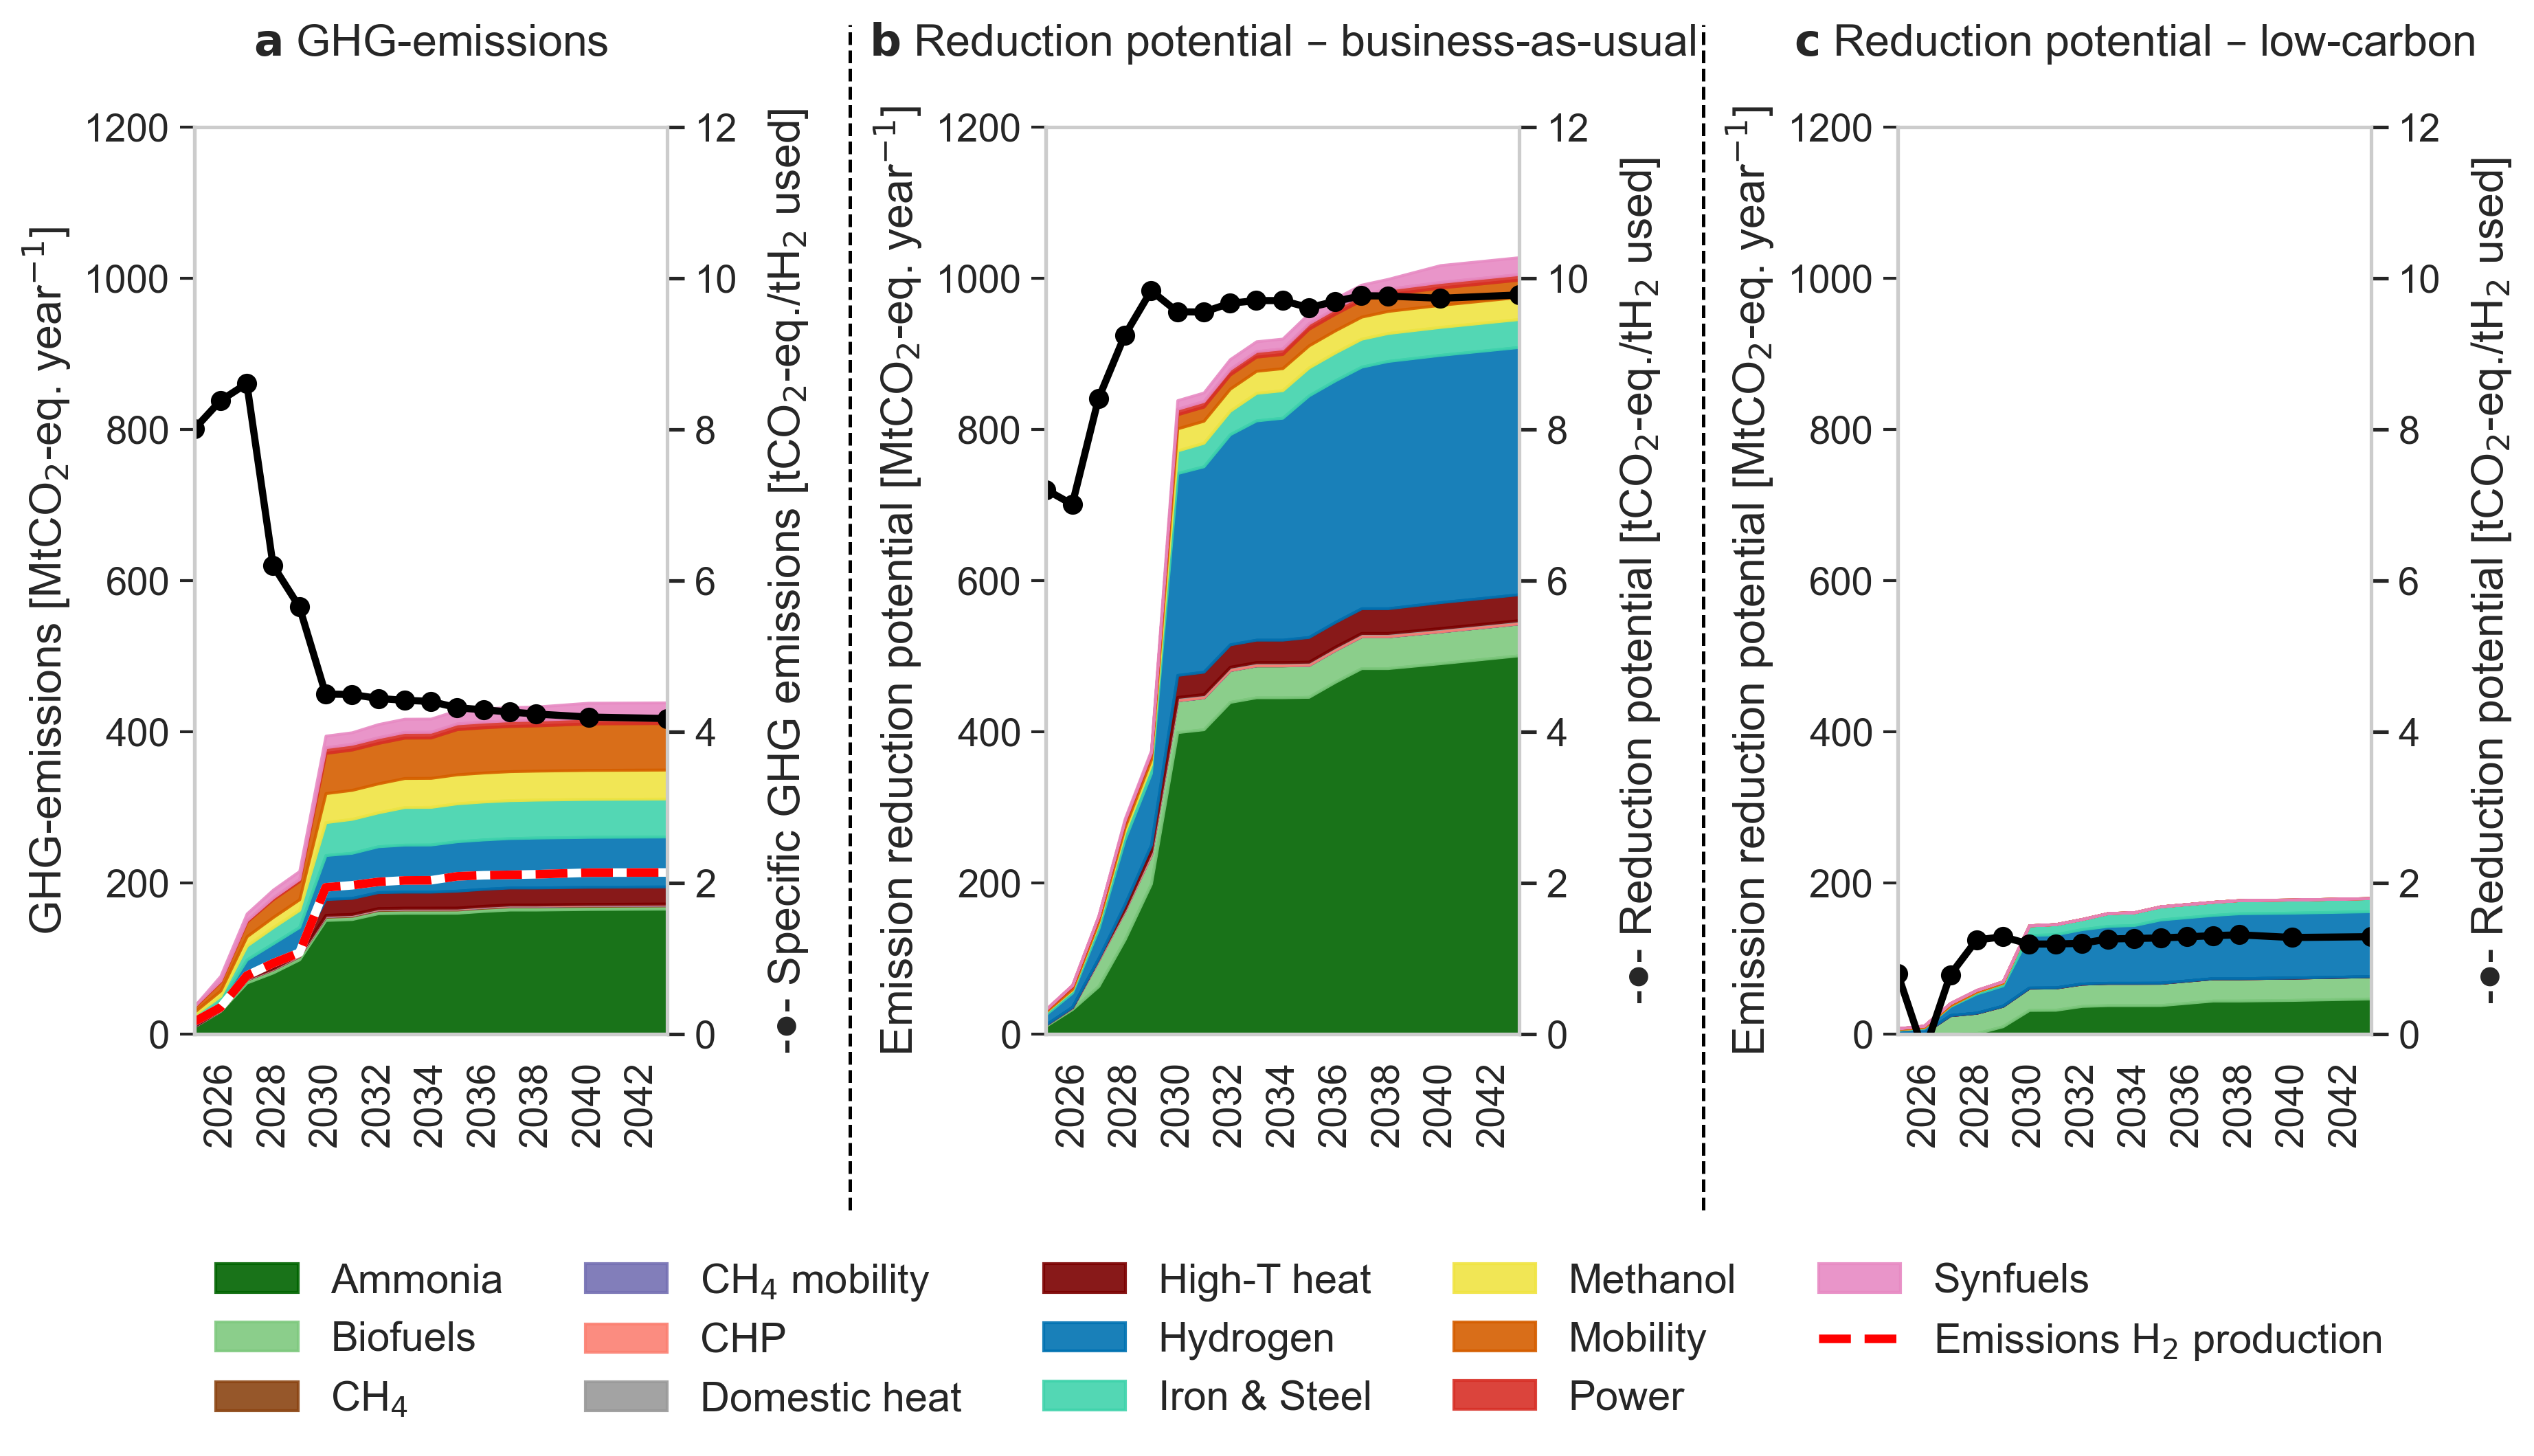

In [49]:
font_size = 15.5

fig, axes = plt.subplots(1, 3, figsize=(12, 5.5), dpi=300)

# Define your DataFrames and other variables
data_frames = [pivot_df_cc_impact, pivot_df_decarb_impact, pivot_df_decarb_impact_low]
mean_values = [mean_ghg, mean_decarb_ref, mean_decarb_ref_low]  # Replace with actual mean_ghg values for each plot
titles = [r'$\bf{a}$ GHG-emissions', 
          r'$\bf{b}$ Reduction potential – business-as-usual', 
          r'$\bf{c}$ Reduction potential – low-carbon']
prim_y_label = ['GHG-emissions [MtCO$_2$-eq. year$^{-1}$]', 'Emission reduction potential [MtCO$_2$-eq. year$^{-1}$]', 
                'Emission reduction potential [MtCO$_2$-eq. year$^{-1}$]']
sec_y_label = ['-●- Specific GHG emissions [tCO$_2$-eq./tH$_2$ used]', 
               '-●- Reduction potential [tCO$_2$-eq./tH$_2$ used]', '-●- Reduction potential [tCO$_2$-eq./tH$_2$ used]']

alpha_value = 0.9

for i, ax1 in enumerate(axes):
    cumulative_data = data_frames[i]
    mean = mean_values[i]

    bottom = pd.Series([0] * len(cumulative_data.index), index=cumulative_data.index)

    for product in cumulative_data.columns:
        label = {'H2': 'H$_2$', 'CH4': 'CH$_4$', 
                 'CH4 mobility': 'CH$_4$ mobility', 'Other Ind': 'High-temperature heat'}.get(product, product)

        #if i==2:
        #    print(end_product_colors[product])
        #    print(product, cumulative_data[product])
        ax1.fill_between(
            cumulative_data.index,
            bottom,
            bottom + cumulative_data[product],
            color=end_product_colors[product],
            alpha=alpha_value,
            label=label,
            linewidth=1
        )
        bottom += cumulative_data[product]

    ax1.set_ylabel(prim_y_label[i], fontsize=font_size)
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

    ax1.set_xlim(cumulative_data.index.min(), cumulative_data.index.max())
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(2))
    ax1.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:0.0f}'))
    ax1.tick_params(axis='x', which='both', labelsize=font_size-2, rotation=90)
    ax1.tick_params(axis='y', which='both', labelsize=font_size-2, width=1, length=5)

    ax1.set_ylim(0, 1200)
    ax1.set_title(titles[i], fontsize=font_size, y=1.06)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    ax1.grid(False) 

    if i==0:
        ax1.plot(pivot_df_cc_impact_h2.sum(axis=1), color='white', lw=3,  )
        ax1.plot(pivot_df_cc_impact_h2.sum(axis=1), color='red', lw=3, linestyle ='dashed', label = 'Emissions H$_2$ production', zorder=10000  )
        ax1.legend(bbox_to_anchor=(4.7, -0.21), fontsize=14.3, title_fontsize='13', frameon=False, ncols=5)

    if mean is not None and len(mean) > 0:
        ax2 = ax1.twinx()
        ax2.plot(
            mean.index,
            mean.values,
            color='black',
            marker='o',
            linestyle='-',
            linewidth=2.5,
            markersize=6,
            zorder=-10,
            label = sec_y_label[i]
        )
        ax2.set_ylabel(sec_y_label[i], fontsize=font_size, labelpad=10)
        ax2.tick_params(axis='y', labelsize=font_size-2)
        ax2.set_ylim(0, 12)
        ax2.grid(False)

fig.tight_layout(pad=3.0)
fig.subplots_adjust(wspace=0.8, top=0.92, bottom=0.12, left=0.08, right=0.96)

line = plt.Line2D([0.345, 0.345], [-0.035, 1.01], transform=fig.transFigure, color='black', lw=1.2, linestyle='dashed')
fig.add_artist(line)
line = plt.Line2D([0.69, 0.69], [-0.035, 1.01], transform=fig.transFigure, color='black', lw=1.2, linestyle='dashed')
fig.add_artist(line)

plt.savefig('figs/figure_3_combined.png', dpi=300, bbox_inches='tight')
plt.savefig("figs/pdf/figure_3_combined.pdf", dpi=300, bbox_inches='tight')
plt.show()